# Project: Airline Satisfaction

## Professional Path: start2impact University Master Data Science - Final Project

## Author: Giacomo Abramo<br><br>

In [1]:
# Let's import libraries, modules, classes and functions
import warnings
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from scipy.stats import ks_2samp, chi2_contingency, shapiro, f_oneway, levene, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mutual_info_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
import pickle


# Let's import functions from util.py
from util import compare_dataframes, kolmogorov_smirnov_test, is_series_equal_to_range, check_duplicate_rows, find_missing_columns, fill_na_with_regression, count_nan_rows, shapiro_wilk_test, anova_correlation, check_homoscedasticity, chi_square_test, chi_square_test_two_dataframes, is_correlated_chisquared, is_correlated_mutualinfo, plot_correlation_matrix, select_k_best_features, define_models, make_pipeline, make_pipeline2, evaluate_model, evaluate_model2, robust_evaluate_model, robust_evaluate_model2, evaluate_models, evaluate_models2, summarize_results, plot_chi_squared_selection_features, plot_mutual_information_selection_features, plot_f_values_selection_features, hyper_tuning      


# Let's set some settings
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2


In [2]:
# Let's import the dataset and carry out some checks

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(compare_dataframes(train, test, "train set", "test set"))
print("\n\n")
print(kolmogorov_smirnov_test(train.drop("satisfaction", axis=1), test.drop("satisfaction", axis=1)))

# In this project we already have the distinction between train and test set. It is important to verify if these two set comes from the same distribution. We verify that with the "two-sample Kolmogorov-Smirnov test" for each variable
# Only "Unnamed: 0" doesn't pass the Kolmogorov-Sminorv test. We'll analyze this feature afterwards

The number of columns in train set and test set are the same.
The column names in train set and test set are the same.
None



Reject the null hypothesis for column Unnamed: 0, the two samples do not come from the same distribution.
None


## A first look to the dataset

In [3]:
# Let's look at a few lines to get a first view of the dataset

train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
# Let's repeat the same code for test set

test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


## Cleaning and preliminary operations

In [5]:
# Let's verify if some variables aren't certainly useful for our purpose i.e. if it is sure that some variables cannot help us to predict "satisfaction"

# "Unnamed: 0" has no clear meaning but it seems to assumes the exact values of the row index; let's verify this intuition
print(is_series_equal_to_range(train["Unnamed: 0"], 0, len(train)))
print(is_series_equal_to_range(test["Unnamed: 0"], 0, len(test)))
# "Unnamed: 0" has the exact values of the row index; we can drop this variable (in this way we have solved also the problem of the Kolmogorov-Sminorv test)


# "id" has a clear meaning and it isn't useful; we can drop this variable

train = train.drop(["Unnamed: 0", "id"], axis=1)
test = test.drop(["Unnamed: 0", "id"], axis=1)

True
True


In [6]:
# Let's verify if there are duplicate_rows on the entire dataset

check_duplicate_rows(pd.concat([train, test]))

There are NO duplicate rows in the dataframe.


False

In [7]:
# Let's verify if there are missing values and the type of variables

print(train.info())
print("\n\n")
print(test.info())
print("\n\n")
print(find_missing_columns(train))
print("\n\n")
print(find_missing_columns(test))

# All the variables except "Arrival Delay in Minutes" haven't missing values
# We can improve the type of some variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

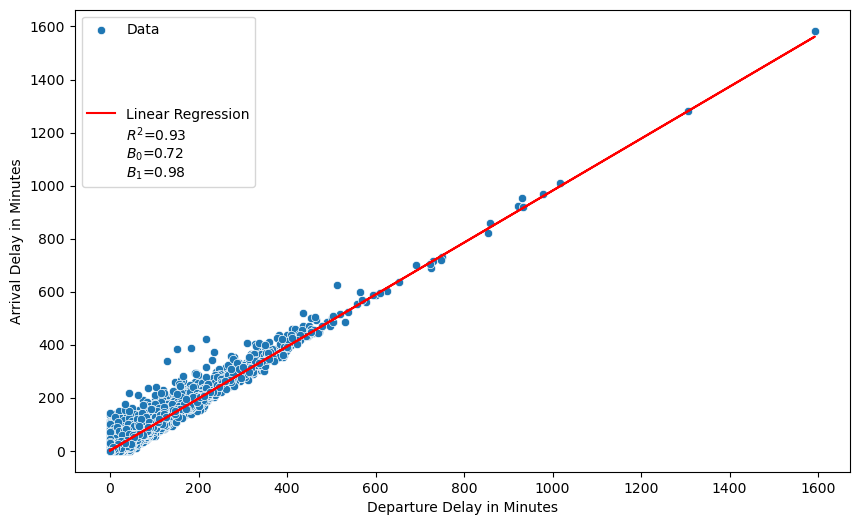

In [8]:
# Observing the structure of the dataset we can check if there is a way to impute missing values relative to "Arrival Delay in Minutes". In my opinion "Departure Delay in Minutes" can play a key role given that I expect a linear correlation. Let's check their relation


train_clean = train.dropna(subset=["Departure Delay in Minutes", "Arrival Delay in Minutes"])

X = train_clean["Departure Delay in Minutes"].values.reshape(-1, 1)
y = train_clean["Arrival Delay in Minutes"].values


model = LinearRegression()
model.fit(X, y)


y_pred = model.predict(X)


r2 = r2_score(y, y_pred)


B0 = model.intercept_
B1 = model.coef_[0]


plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_clean["Departure Delay in Minutes"], y=train_clean["Arrival Delay in Minutes"], label='Data')
plt.plot(train_clean["Departure Delay in Minutes"], y_pred, color='red', label=f'\n\n\n\nLinear Regression\n$R^2$={r2:.2f}\n$B_0$={B0:.2f}\n$B_1$={B1:.2f}')
plt.xlabel('Departure Delay in Minutes')
plt.ylabel('Arrival Delay in Minutes')
plt.legend()
plt.show()

In [9]:
# We substitute missing values in "Arrival Delay in Minutes" in the train set and test set with values obtained with B0 and B1 observing only train data (in order to avoid "data leakage")

train["Arrival Delay in Minutes"] = train.apply(fill_na_with_regression, axis=1, args=(B0, B1))
test["Arrival Delay in Minutes"] = test.apply(fill_na_with_regression, axis=1, args=(B0, B1))

In [10]:
# In order to achieve memory savings, speed of operations and semantic clarity we trasform some variables from object to category

columns_to_category = ["Gender", "Customer Type", "Type of Travel", "Class", "Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service", "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "Cleanliness", "satisfaction"]  
train[columns_to_category] = train[columns_to_category].astype('category')
test[columns_to_category] = test[columns_to_category].astype('category')

In [11]:
print(train.info())
print("\n\n")
print(test.info())
print("\n\n")
print(find_missing_columns(train))
print("\n\n")
print(find_missing_columns(test))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103904 non-null  category
 1   Customer Type                      103904 non-null  category
 2   Age                                103904 non-null  int64   
 3   Type of Travel                     103904 non-null  category
 4   Class                              103904 non-null  category
 5   Flight Distance                    103904 non-null  int64   
 6   Inflight wifi service              103904 non-null  category
 7   Departure/Arrival time convenient  103904 non-null  category
 8   Ease of Online booking             103904 non-null  category
 9   Gate location                      103904 non-null  category
 10  Food and drink                     103904 non-null  category
 11  Online boarding           

**Everything we have done so far has turned out to be strictly necessary to apply the first baseline models (i.e. models that do not exploit any particular processing technique deriving from analysis). The only processing operation carried out was that relating to missing values; this operation was necessary as the models would not have been able to work.**

# BASELINE MODELS 

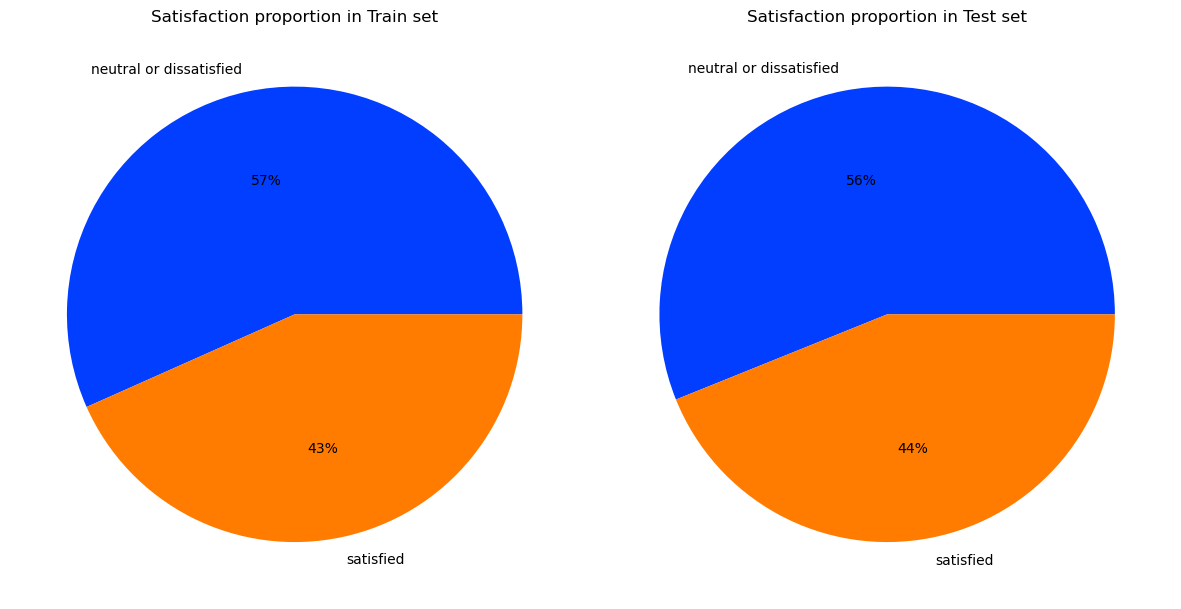

In [12]:
# Preliminary activity

X_train, y_train, X_test, y_test = train.drop("satisfaction", axis=1), train["satisfaction"], test.drop("satisfaction", axis=1), test["satisfaction"]


# Transformation of categorical variables with "string" values. This operation, like handling NaN, is necessary as the models would not able to work.

# We apply LabelEncoder transformation to dicotomic variables
le = LabelEncoder()

for column in ["Gender", "Customer Type", "Type of Travel"]:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])
    
# We apply OrdinalEncoder to "Class" because ECO < ECO PLUS < BUSINESS 
order = ["Eco", "Eco Plus", "Business"]
oe = OrdinalEncoder(categories = [order])
X_train["Class"] = oe.fit_transform(X_train[["Class"]])
X_test["Class"] = oe.transform(X_test[["Class"]])



train_labels = sorted(train.satisfaction.unique())
test_labels = sorted(test.satisfaction.unique())


train_counts = [train.satisfaction.value_counts()[label] for label in train_labels]
test_counts = [test.satisfaction.value_counts()[label] for label in test_labels]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(train_counts, 
            labels=train_labels, 
            colors=sns.color_palette('bright'), 
            autopct='%.0f%%')
axes[0].set_title('Satisfaction proportion in Train set')


axes[1].pie(test_counts, 
            labels=test_labels, 
            colors=sns.color_palette('bright'), 
            autopct='%.0f%%')
axes[1].set_title('Satisfaction proportion in Test set')

plt.tight_layout()
plt.show()

# In train and test set there isn't a problem of unbalanced target 
# Therefore, in the train set is not necessary to consider unbalancing problems (like class_weight) and in the test set accuracy can be a good metric 
# ACCURACY is a metric that measures how often a machine learning model correctly predicts the outcome (TP + TN)/(TP + TN + FP + FN)

*The project requires using three models; two of them must be the Random Forest Classifier and the Adaboost Classifier.*<br>
*The model that I choose is the Extra Trees Classifier. It is a tree model with a bagging approach, therefore very similar to the Random Forest. Contrary to the Random Forest, in the Extra Trees the best split point of the features is not searched for, but is calculated randomly. This mechanism significantly lowers the variance in the bias-variance tradeoff, as well as speeding up the training procedure.*<br><br><br>
*The project also requires defining other performance metrics beyond accuracy; let's give a small definition for the best known:<br>*
**1) recall (or sensitivity or true positive rate): is a metric that measures how often a machine learning model correctly identifies positive instances (true positives) from all the actual positive samples in the dataset (TP) / (TP + FN).**<br>
**2) precision: is a metric that measures how often a machine learning model correctly predicts the positive class (TP) / (TP + FP).**<br>
**3) f1-score: is the harmonic mean between recall and precision (2TP) / (2TP + FP +FN).**

In [13]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print("Accuracy on the test set using Random Forest is:", rf.score(X_test, y_test))

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)
print("Accuracy on the test set using AdaBoost is:", ab.score(X_test, y_test))

et = ExtraTreesClassifier(random_state=42, n_jobs=-1)
et.fit(X_train, y_train)
print("Accuracy on the test set using ExtraTreesClassifier is:", et.score(X_test, y_test))

Accuracy on the test set using Random Forest is: 0.962580843855867
Accuracy on the test set using AdaBoost is: 0.9264320911610717
Accuracy on the test set using ExtraTreesClassifier is: 0.9620418848167539


**The results of the three models are quite good; let's see if the Exploratory Data Analysis (EDA) can help us to visualizing useful insight in order to improve models.**

# EXPLORATORY DATA ANALYSIS (EDA)

In [14]:
# We use IsolationForest in order to detect outliers using default hyperparameters

iforest = IsolationForest(random_state=42, n_jobs=-1)
prediction = iforest.fit_predict(X_train)

n_outliers = (prediction == -1).sum()
n_normals = (prediction == 1).sum()

print("Number of outliers detected: {} and their proportion is {}".format(n_outliers, round(n_outliers/len(X_train),2)))
print("Number of normal samples detected: {} and their proportion is {}".format(n_normals, round(n_normals/len(X_train),2)))

# The number of outliers with default values for hyperparameters is incredibly hight. We could choose a low value for the hyperparameter contamination but let's not go down this road

Number of outliers detected: 48078 and their proportion is 0.46
Number of normal samples detected: 55826 and their proportion is 0.54


### UNIVARIATE ANALYSIS
**The univariate approach aims to analyze variables individually; let's see if we can obtain some interesting information.**

In [15]:
train.describe(include=[np.number])

# Numerical variables have different scale. However this is not a problem as the chosen algorithms are not distance based and the cost function is not minimized via iterative algorithms (such as gradient descent).

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,14.815618,15.245019
std,15.114964,997.147281,38.230901,38.802830
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,843.000000,0.000000,0.000000
75%,51.000000,1743.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


In [16]:
train.describe(include=["category"])

# Most of variables are categorical. Many of them are already encoded, others take on string-type values and therefore must be correctly encoded

,Gender,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
count,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904
unique,2,2,2,3,6,6,6,6,6,6,6,6,6,6,5,6,6,6,2
top,Female,Loyal Customer,Business travel,Business,3,4,3,3,4,4,4,4,4,4,4,4,4,4,neutral or dissatisfied
freq,52727,84923,71655,49665,25868,25546,24449,28577,24359,30762,31765,29423,30867,28789,37383,29055,37945,27179,58879


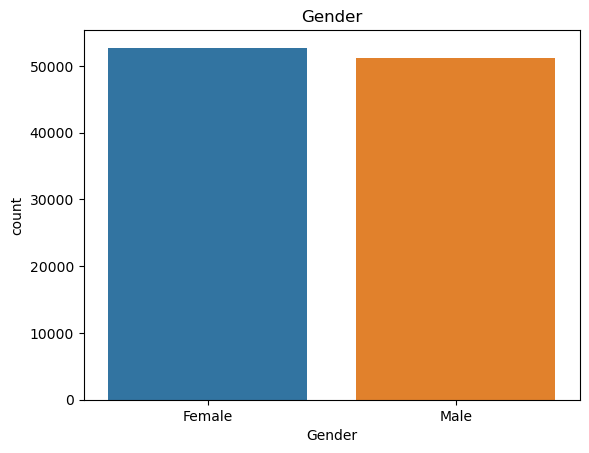

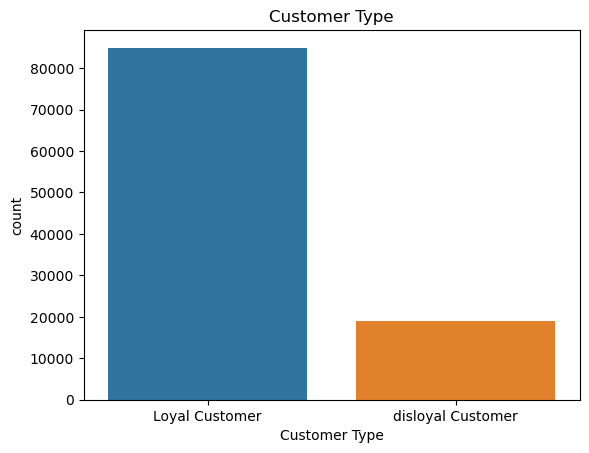

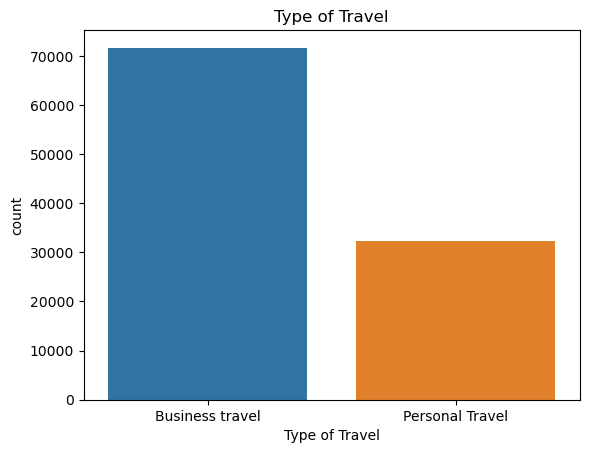

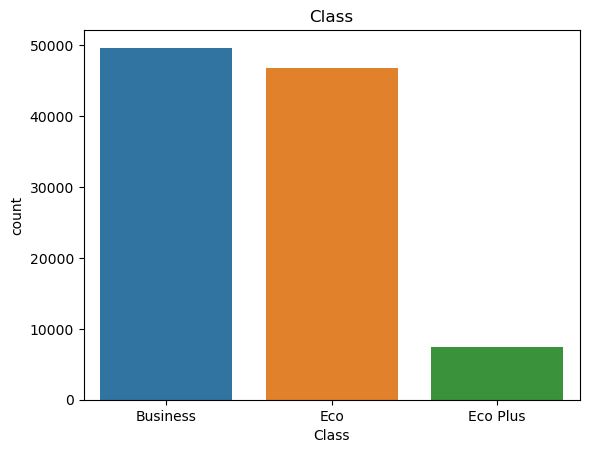

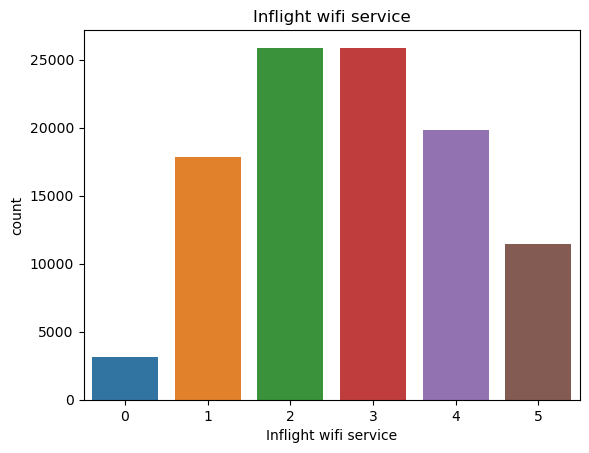

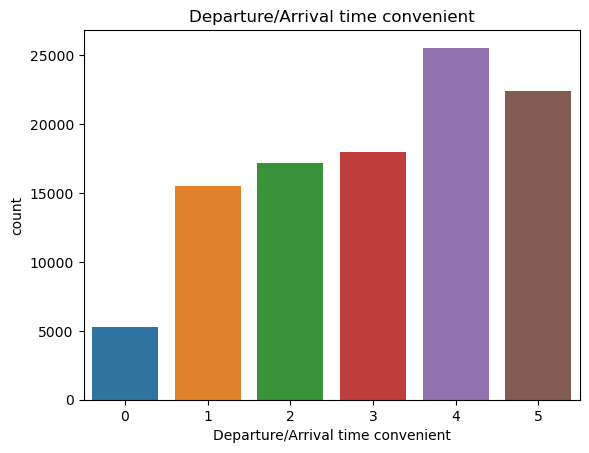

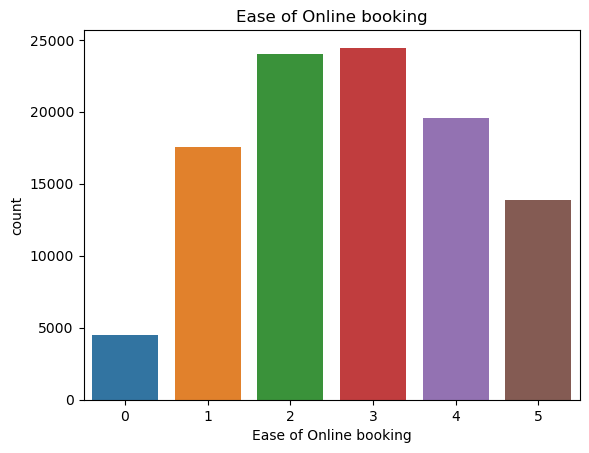

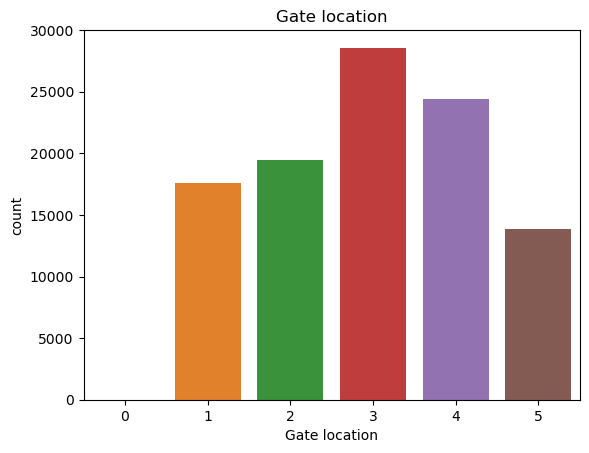

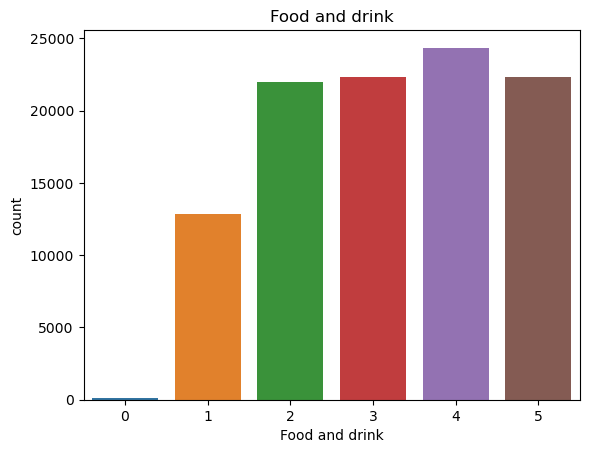

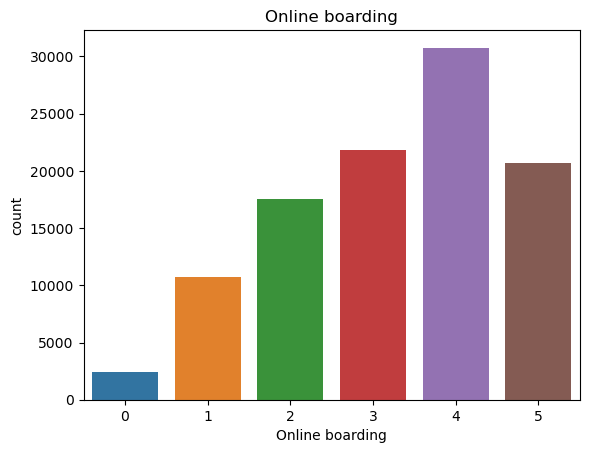

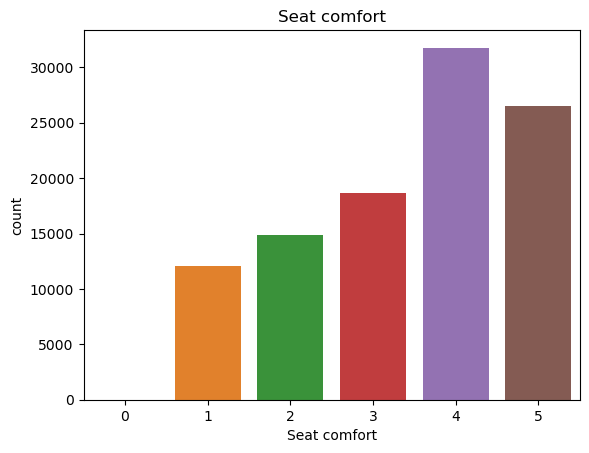

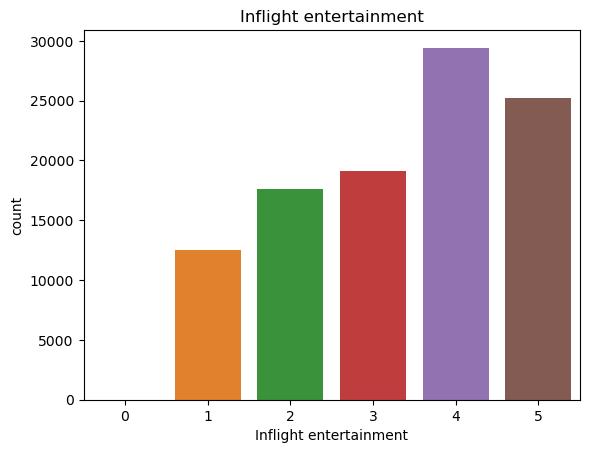

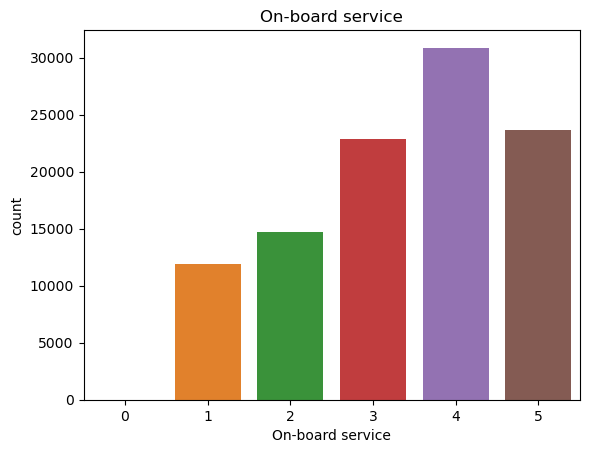

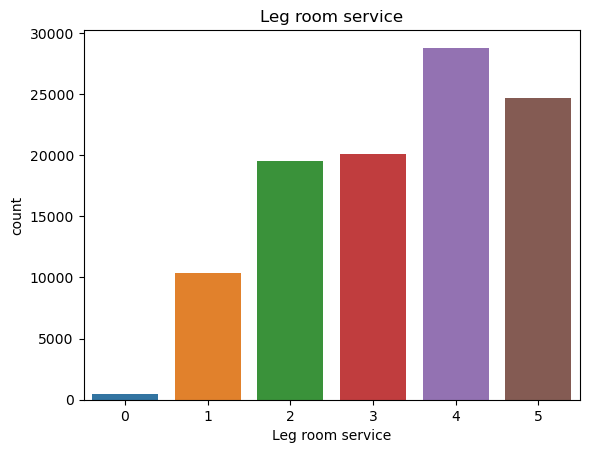

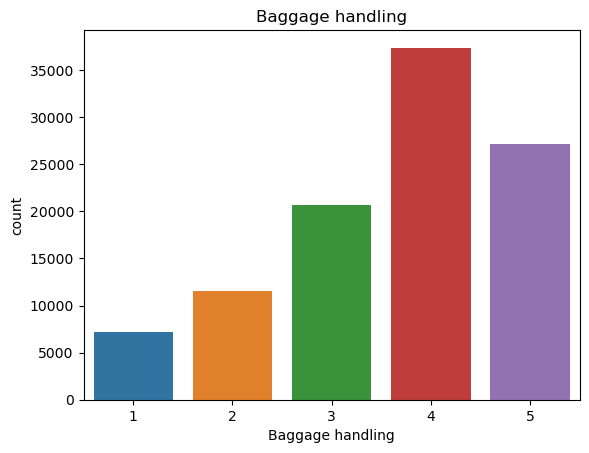

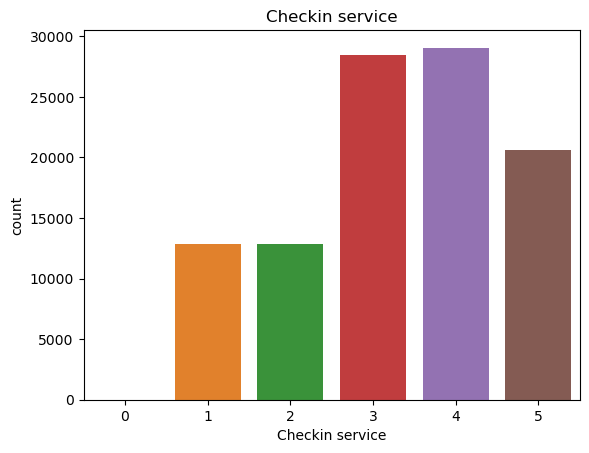

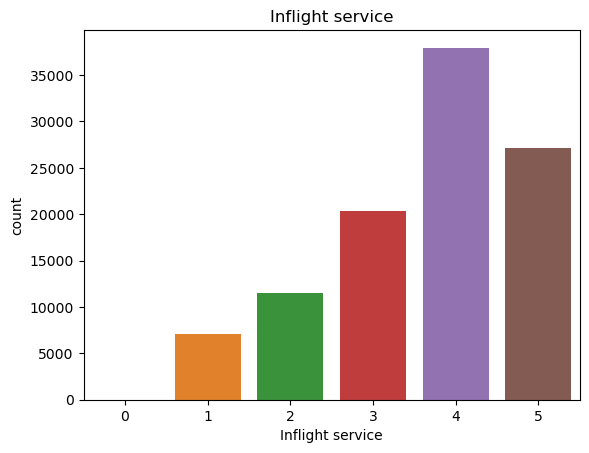

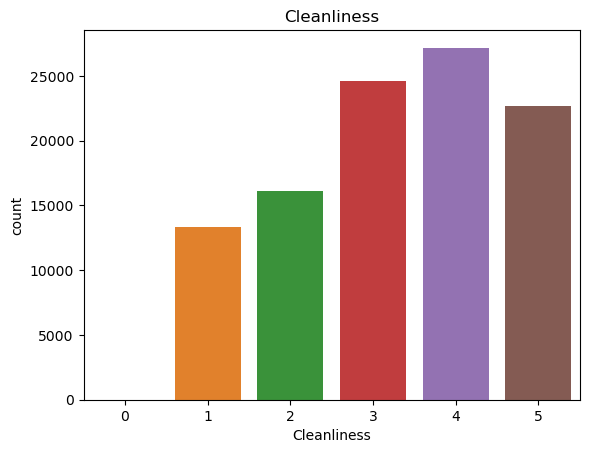

In [17]:
# Analysis of the features individually (categorical variables)

categorical_X = [i for i in list(train.columns) if i not in ('Age', 'Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes','satisfaction')]
for i in categorical_X:
    sns.countplot(x = i, data = train)
    plt.title(i)
    plt.show()

**All the variables above except "Gender", "Customer Type", "Type of Travel"and "Class" are variables which express degree of satisfaction. In this variables, however, could be, im my opinion, an encoding problem due to six unique values. In fact, according to me, while the range 1-5 expresses a satisfaction, the value 0 could expresses an encoding for a missing value and the reduced number of 0 values could be a sign.**

This [link](https://en.wikipedia.org/wiki/Likert_scale) might support my opinion: <<Likert scales typically range from 2 to 10 – with 3, 5, or, 7 being the most common.>> 

**We keep in mind this intuition and we will see if other analyses can help us to choose how to treat these variables.**

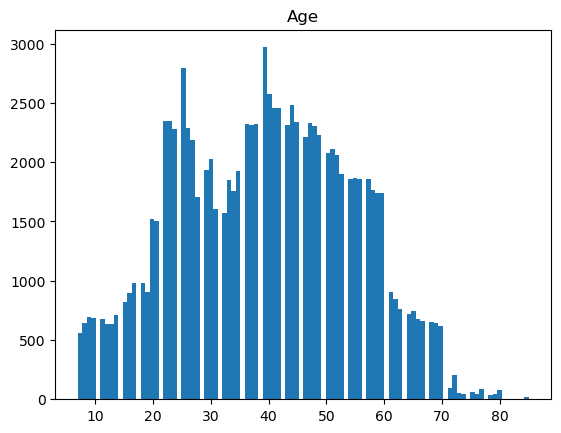

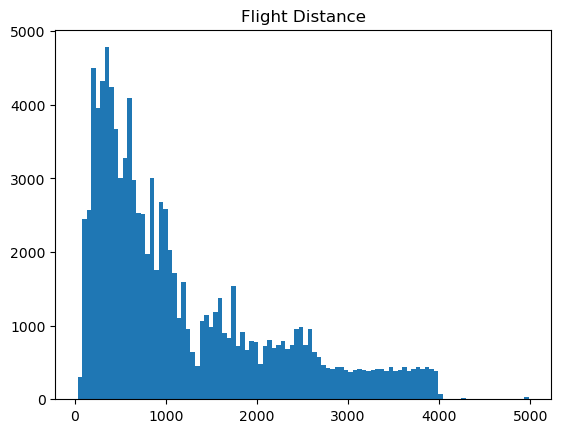

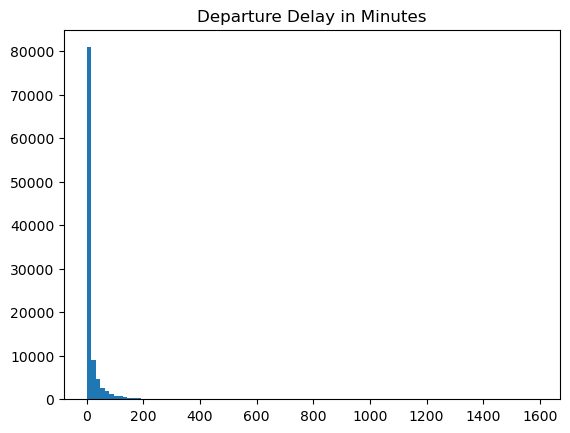

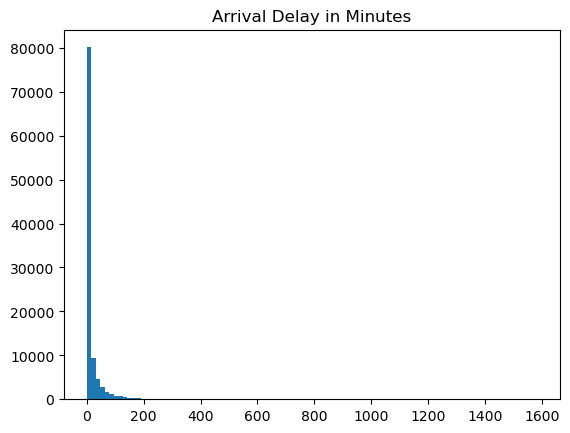

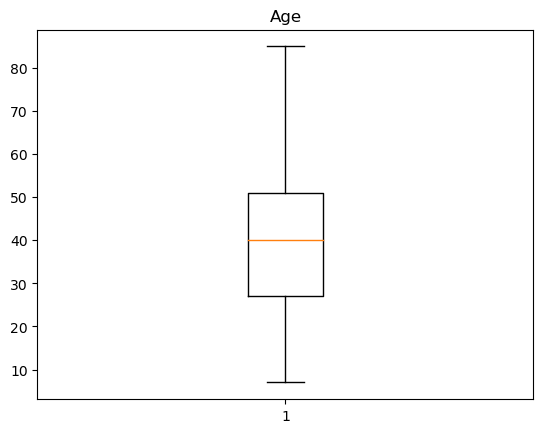

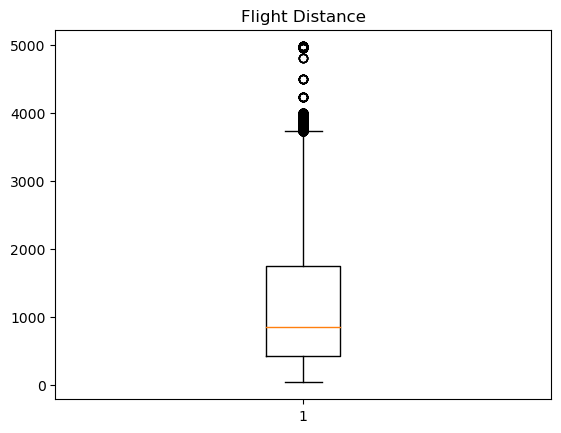

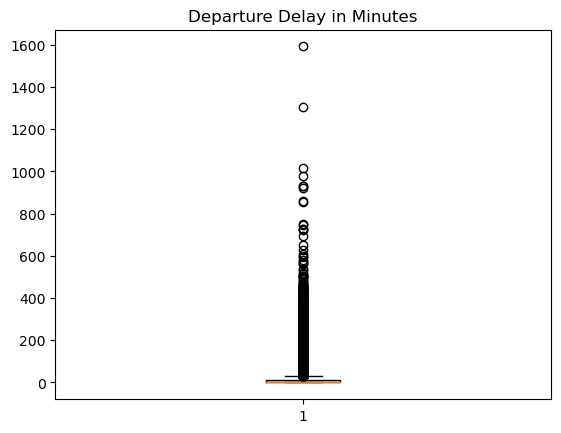

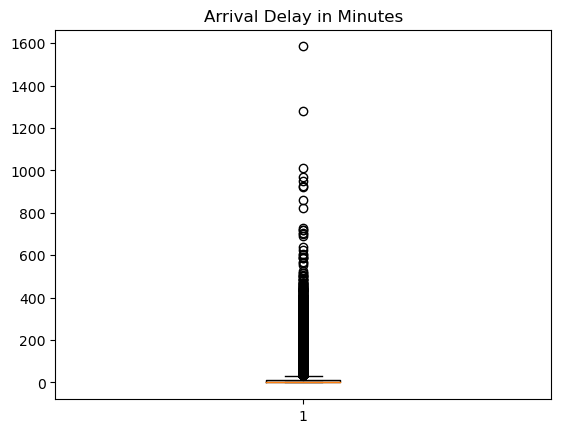

In [18]:
# Analysis of the features individually (numerical variables)

for i in ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]:
    plt.hist(train[i], bins = 100)
    plt.title(i)
    plt.show()
for i in ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]:
    plt.boxplot(train[i])
    plt.title(i)
    plt.show()    

**It seems that variables haven't symmetric distribution; furthermore, some of these, in particular "Arrival Delay in Minutes" and "Departure Delay in Minutes", from a univariate point of view, have many outliers.**

## BIVARIATE ANALYSIS (focus on "satisfaction")
**The bivariate approach aims to analyze pairwise variables; in this step we analyze each variable in relation to "satisfaction" let's see if we can obtain some interesting information.**

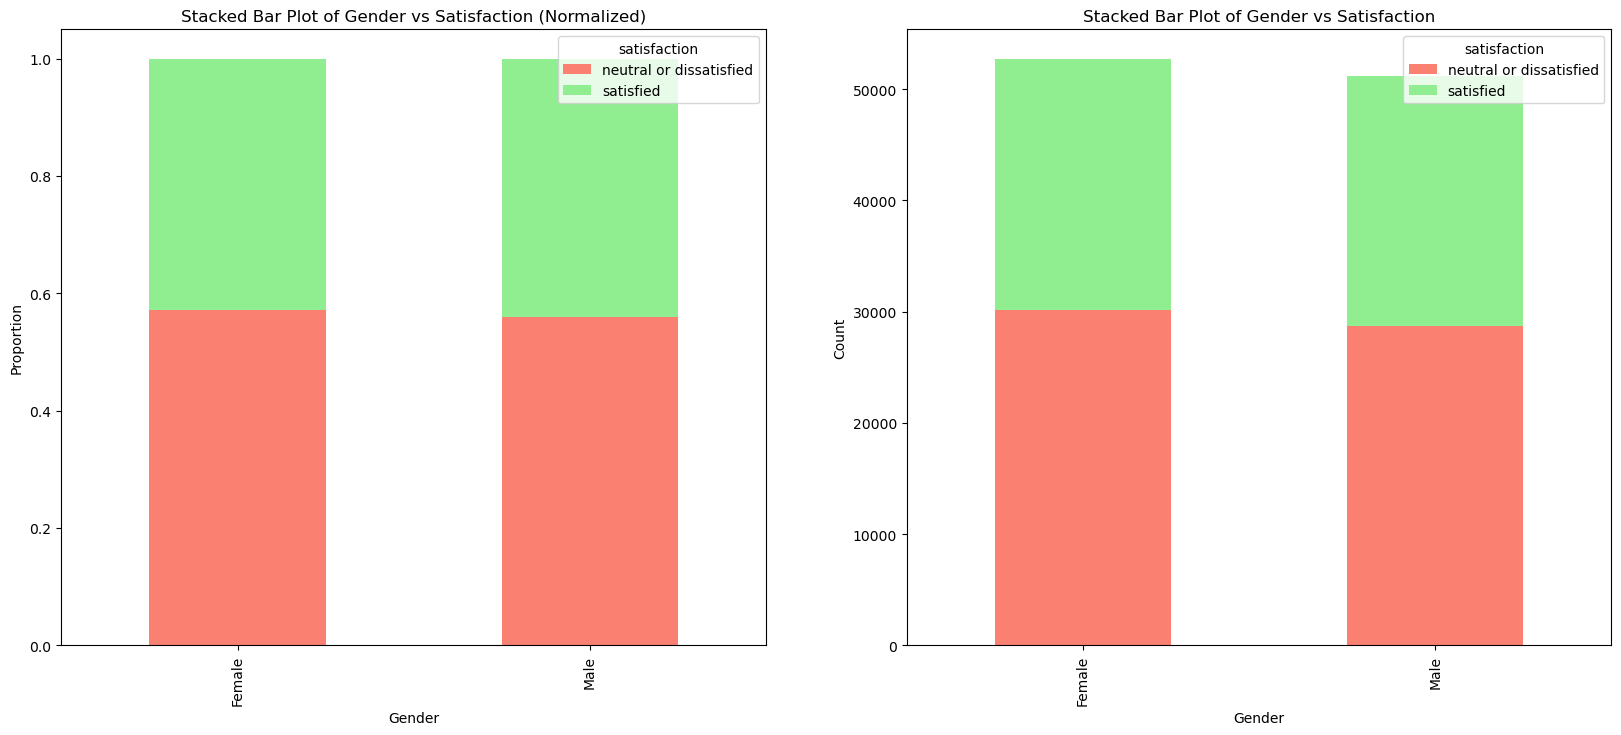

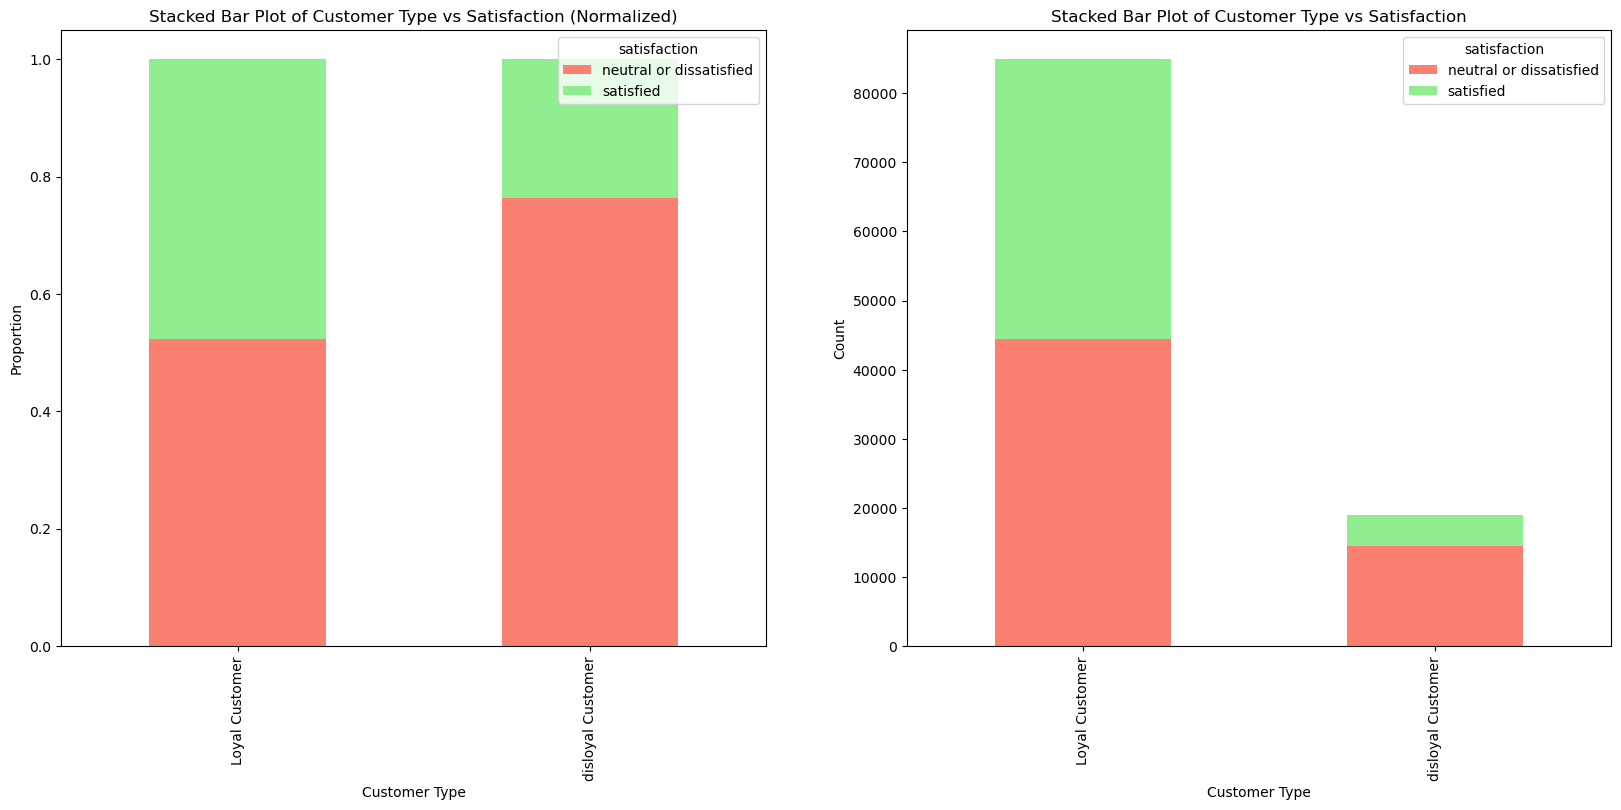

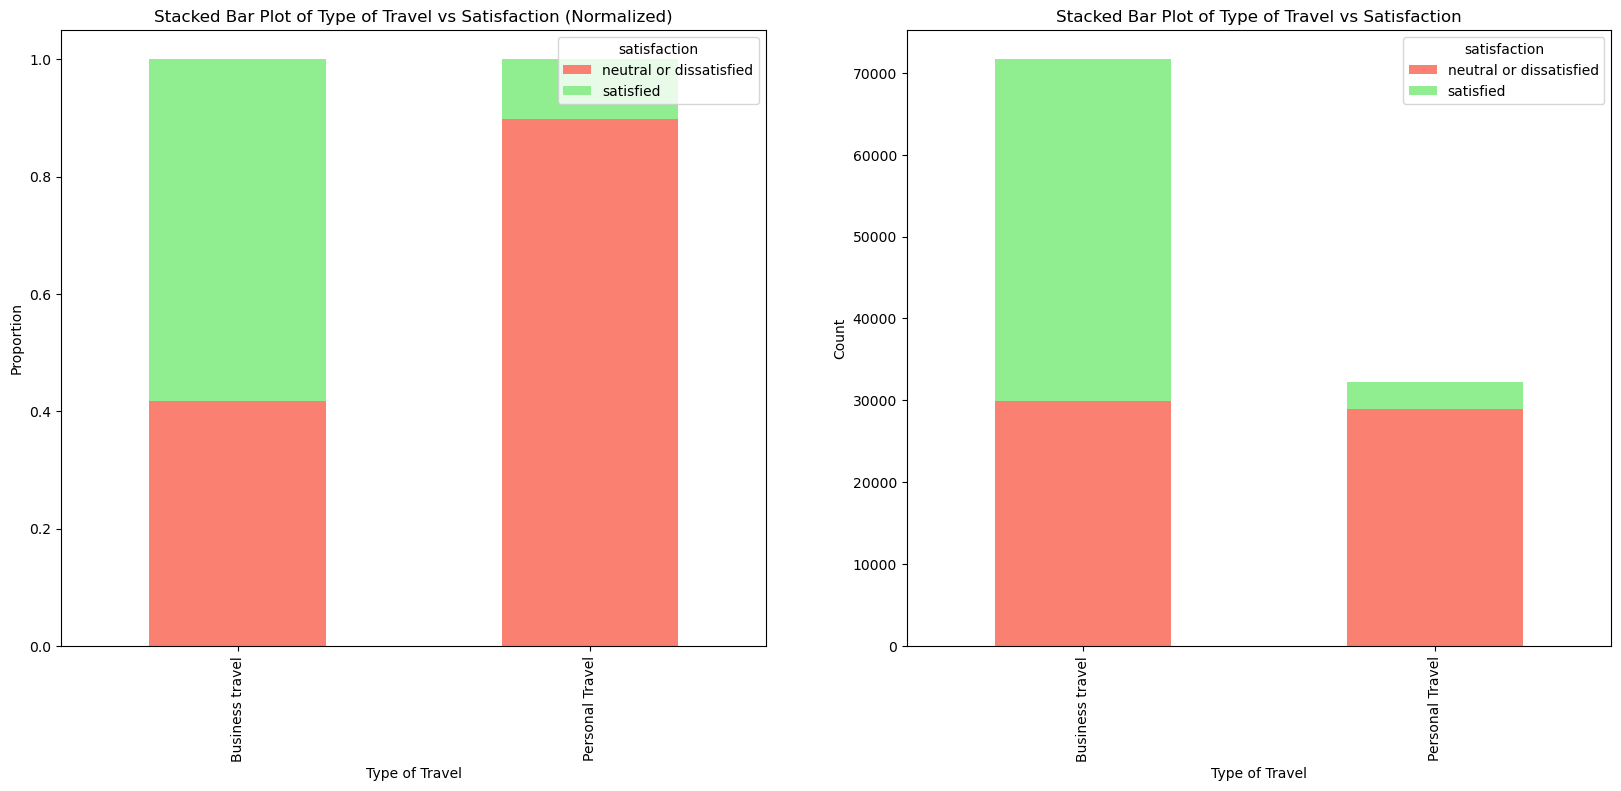

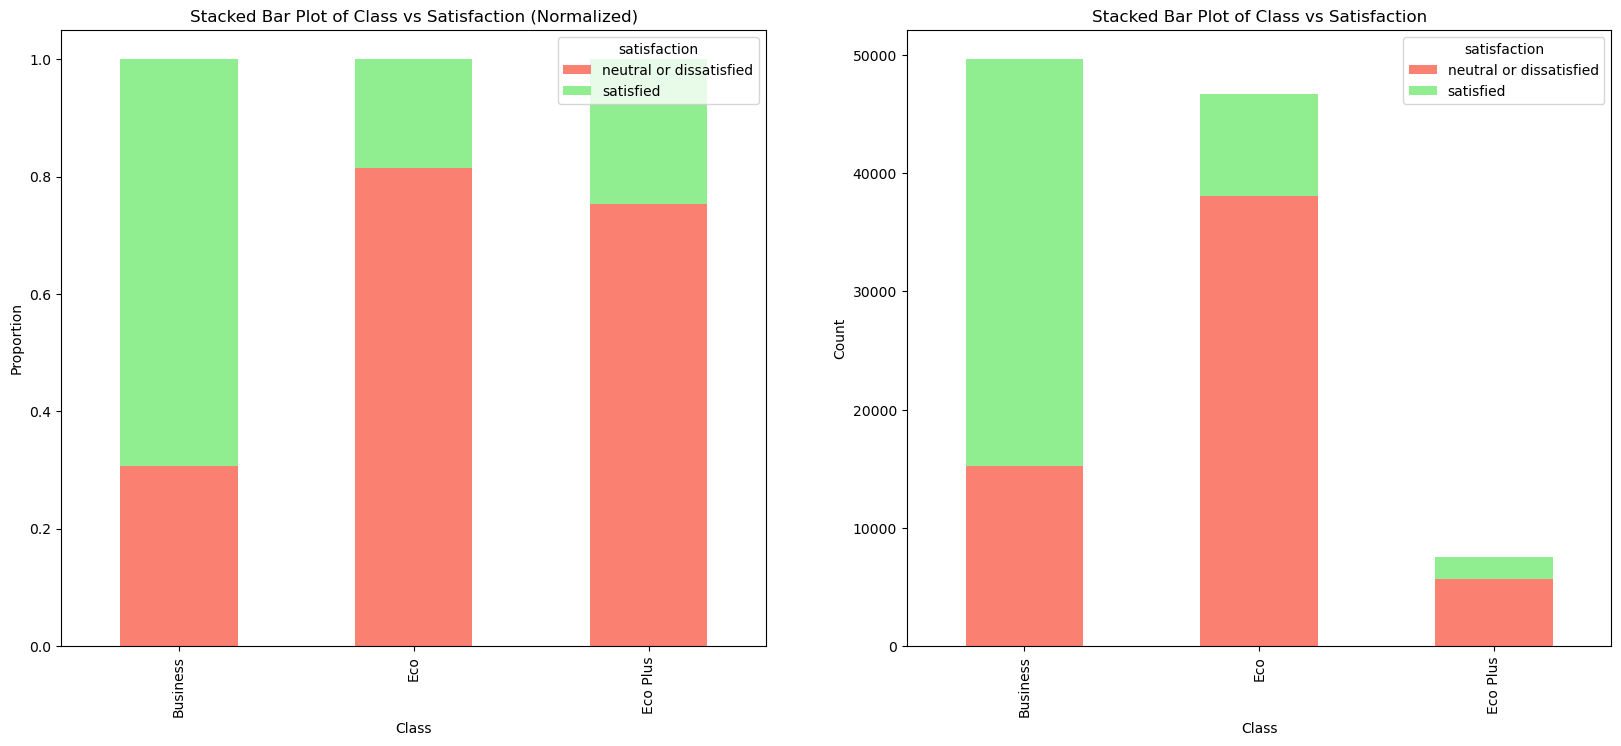

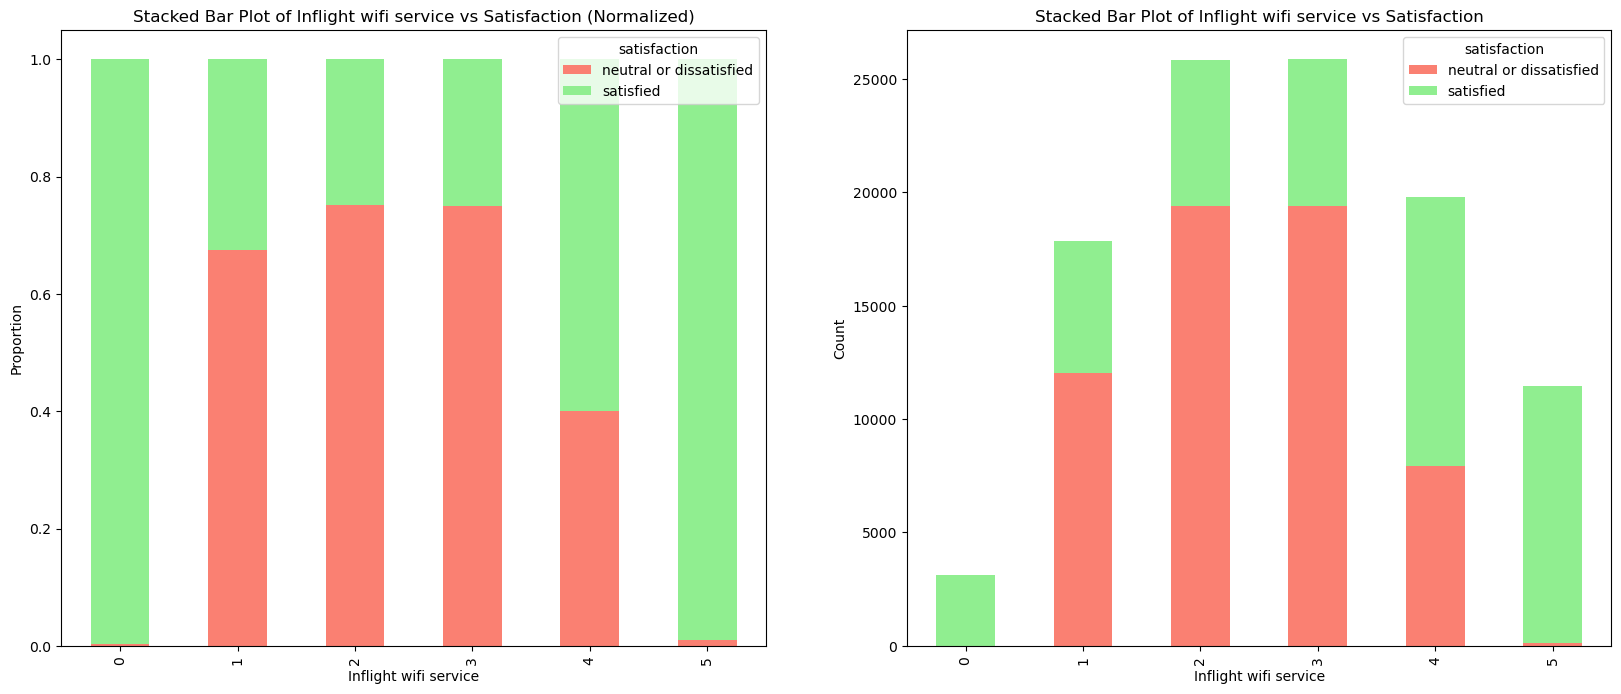

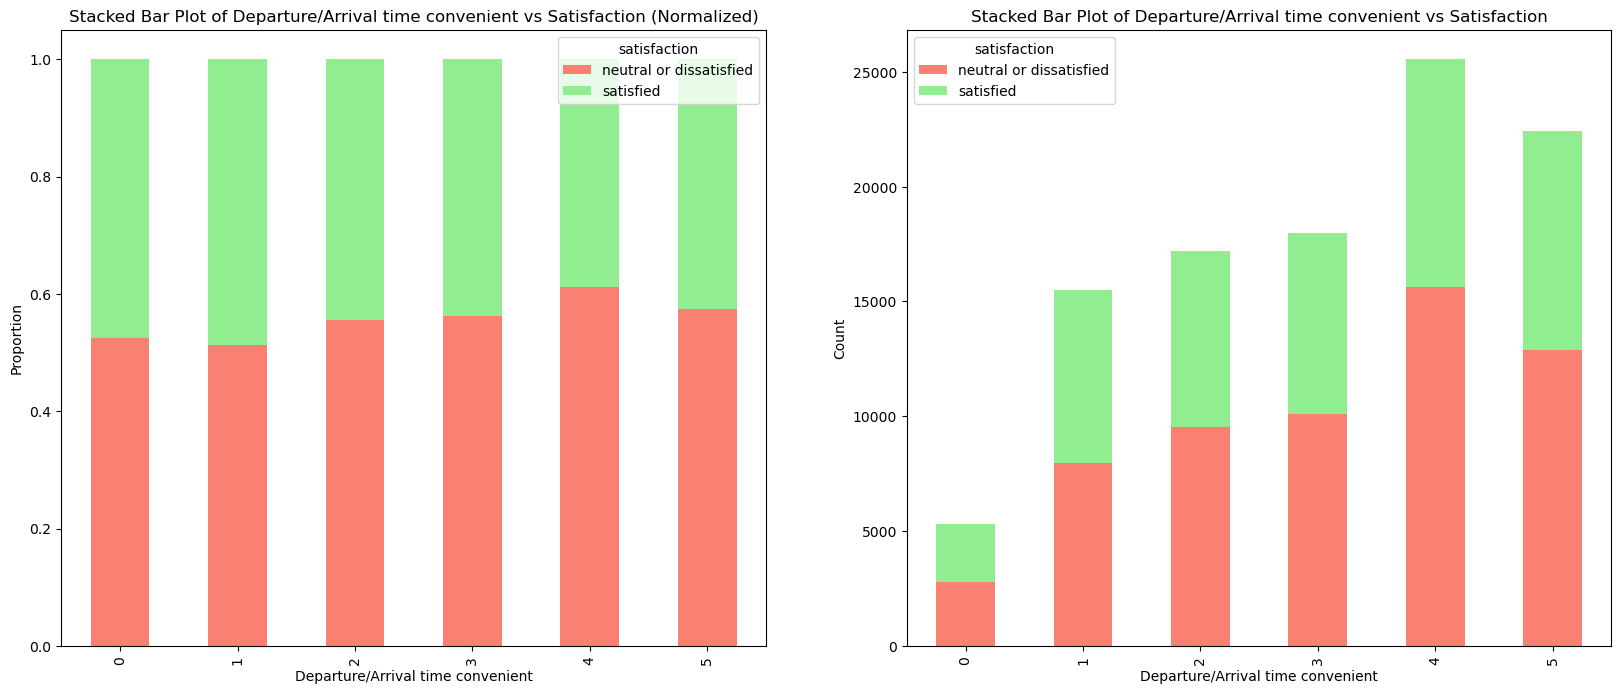

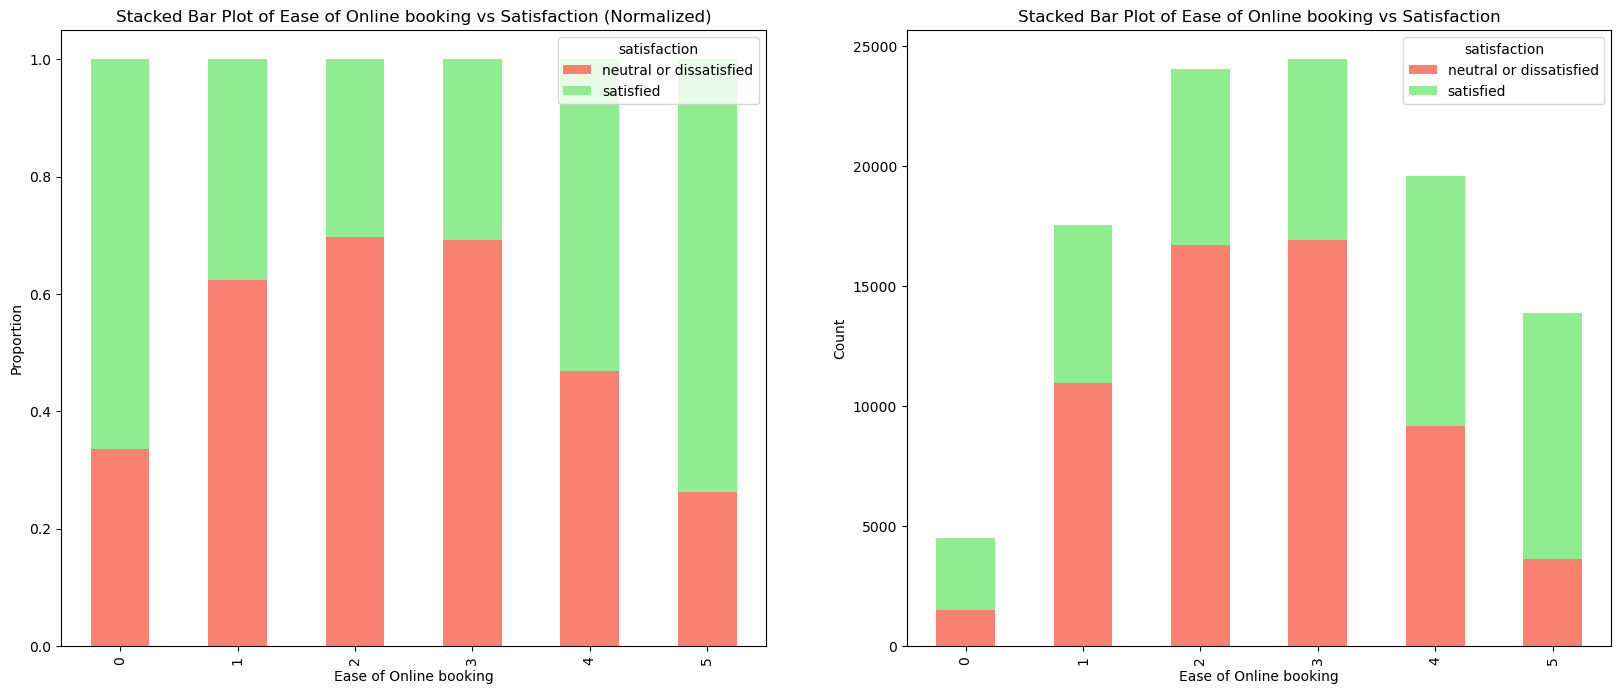

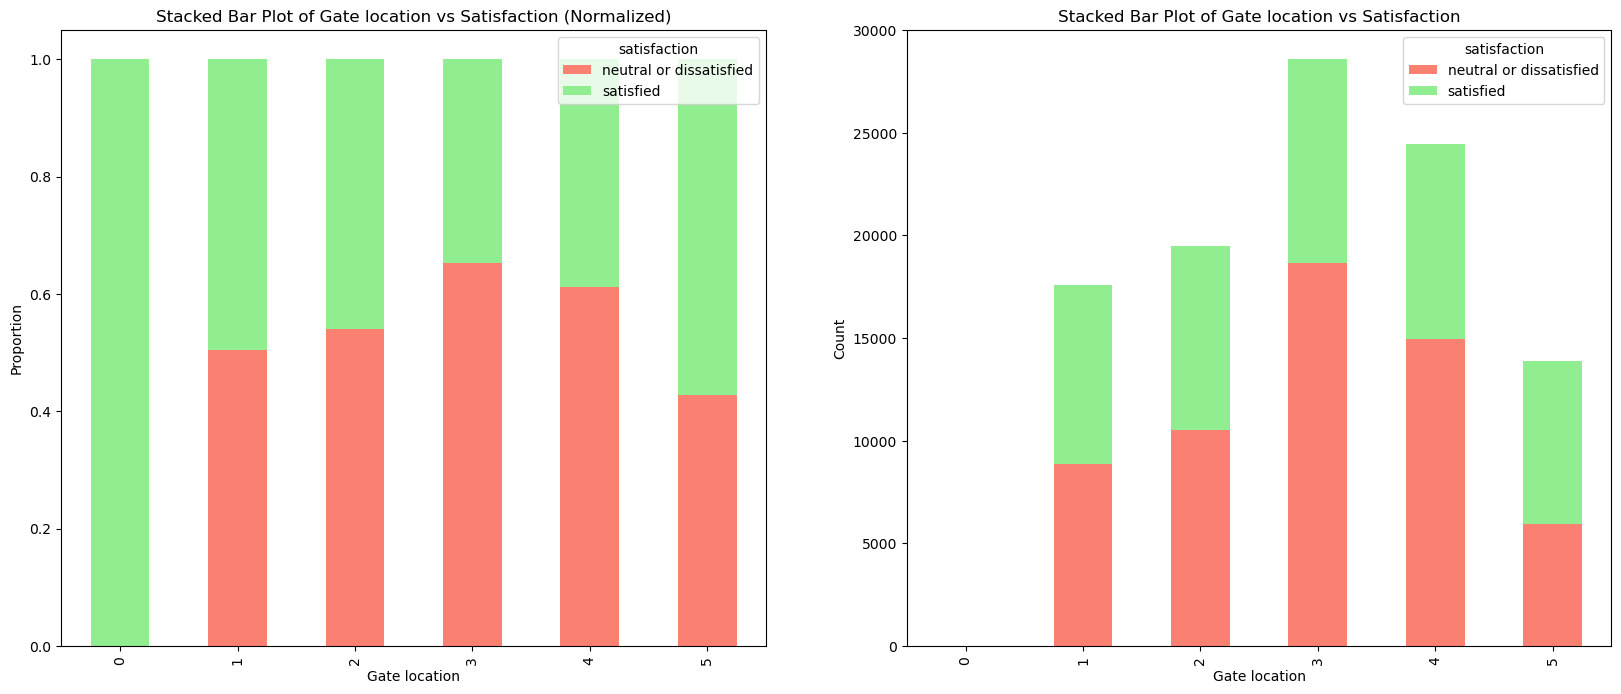

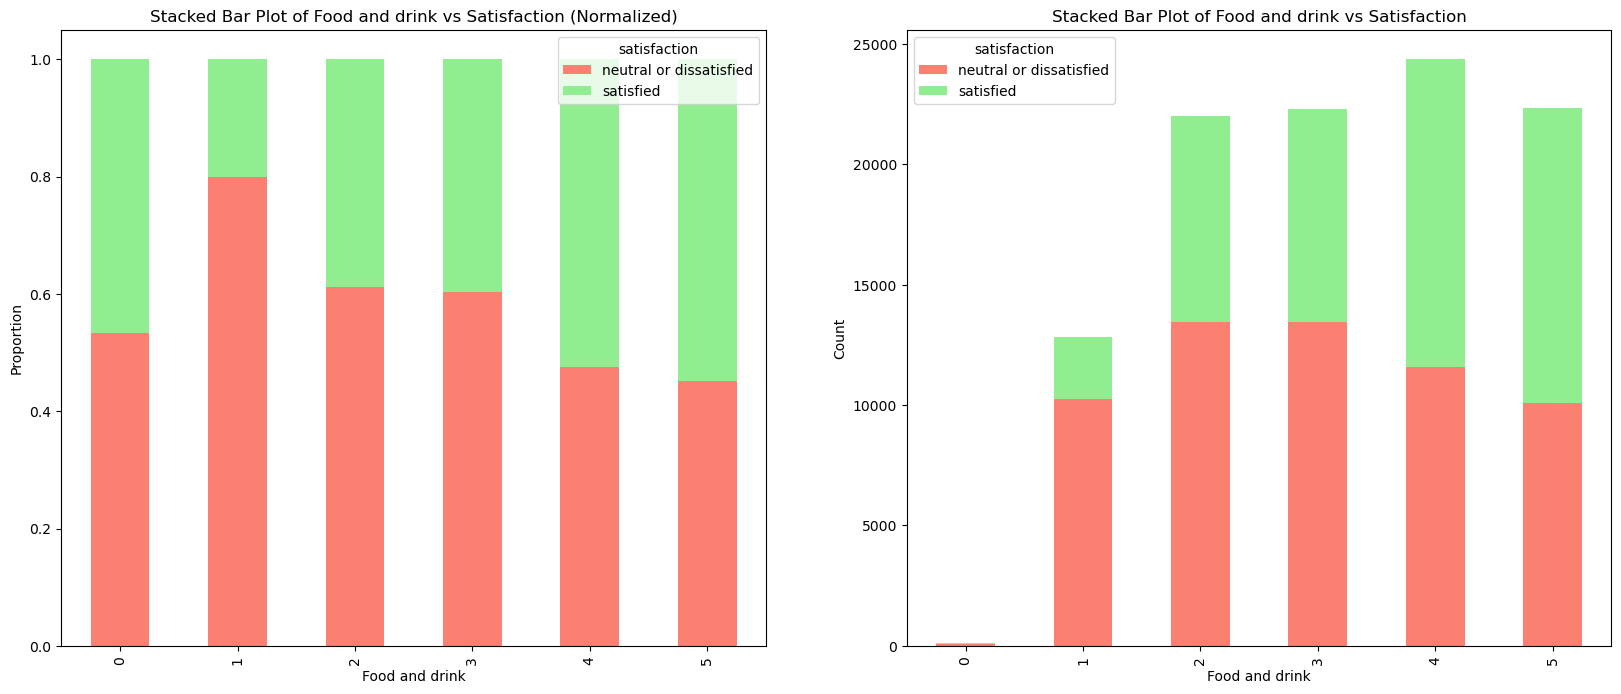

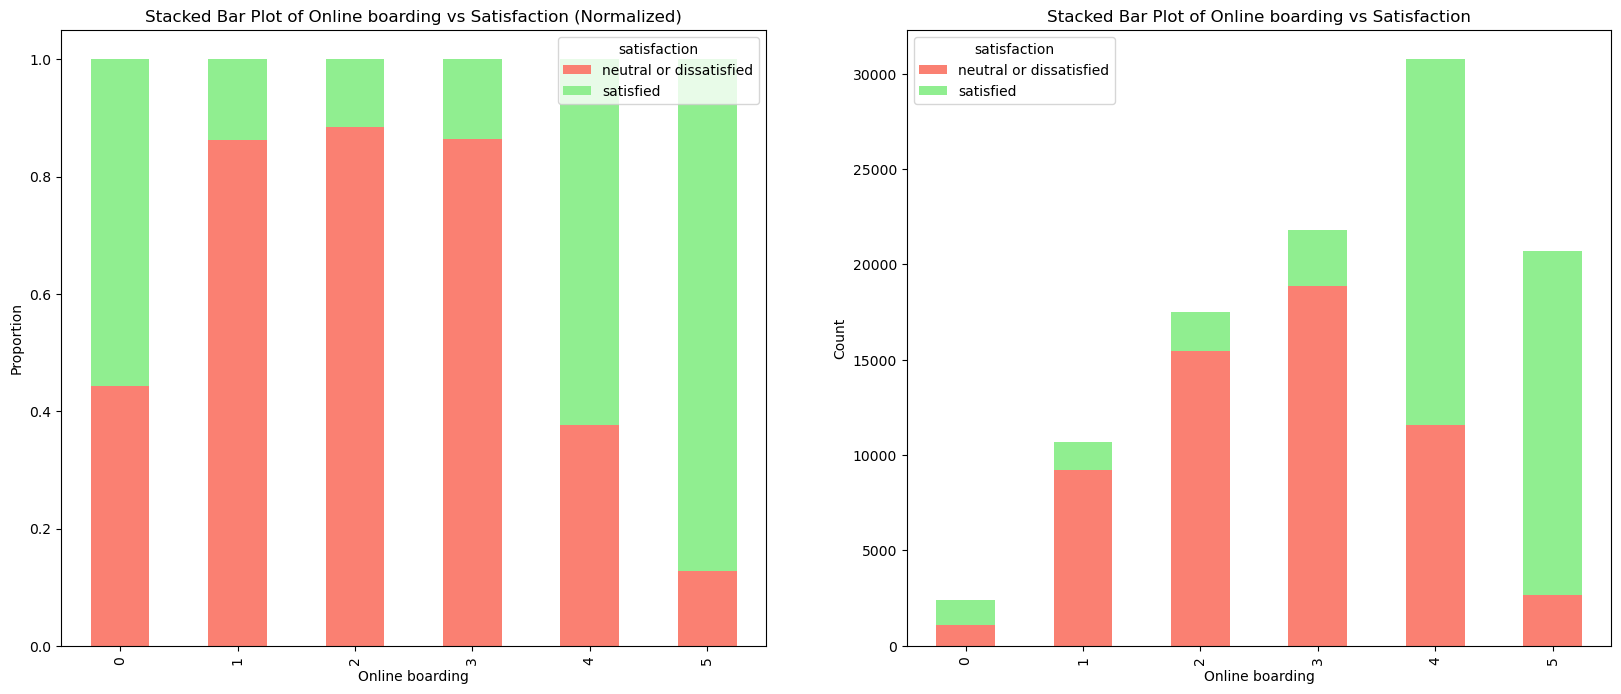

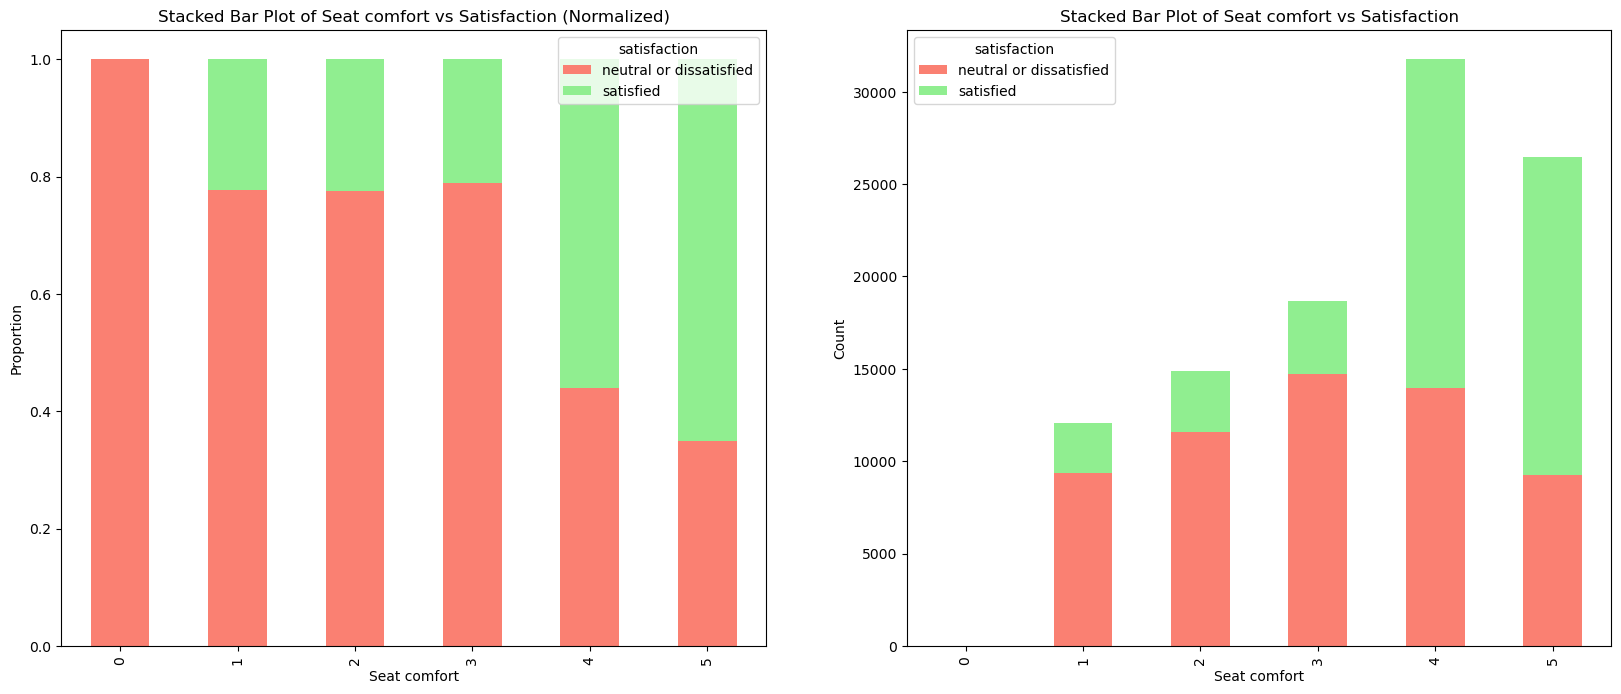

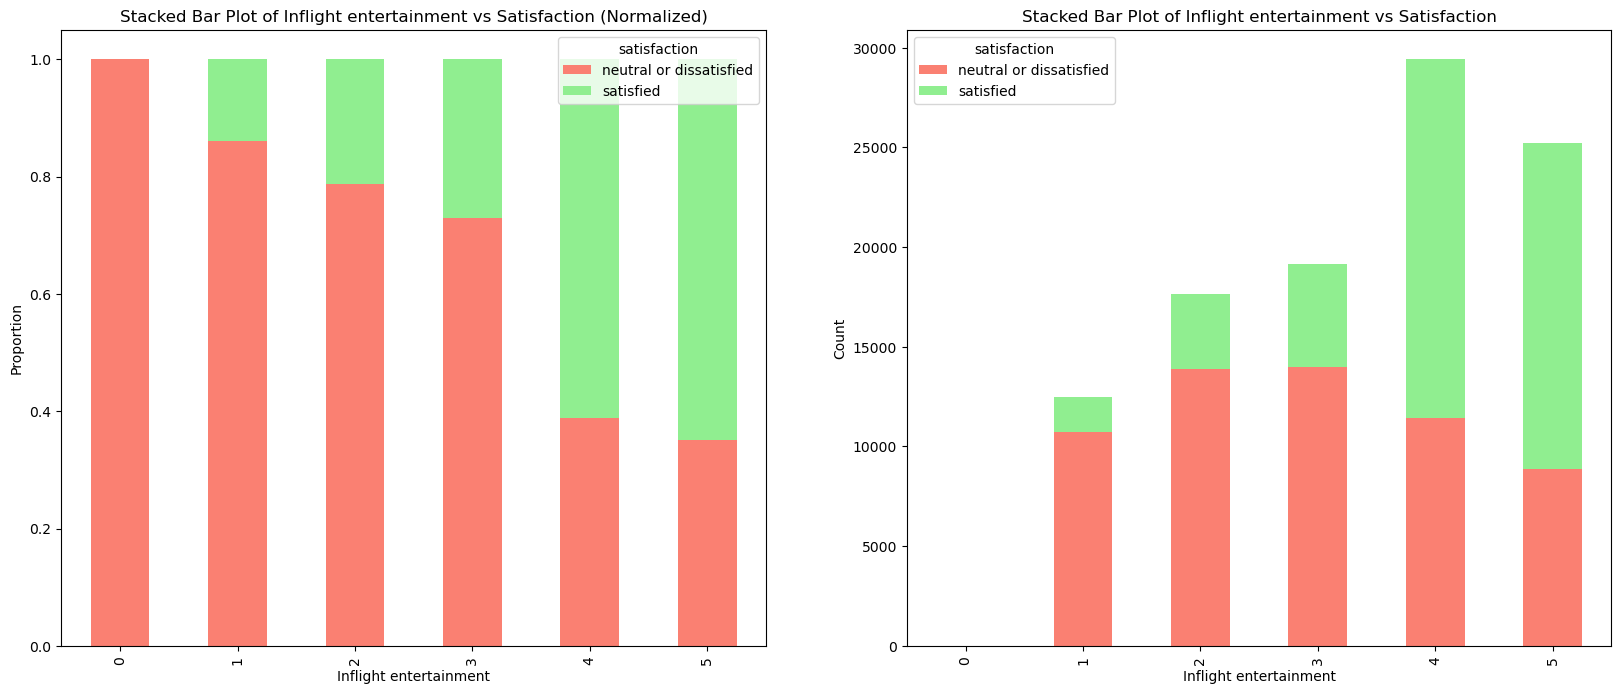

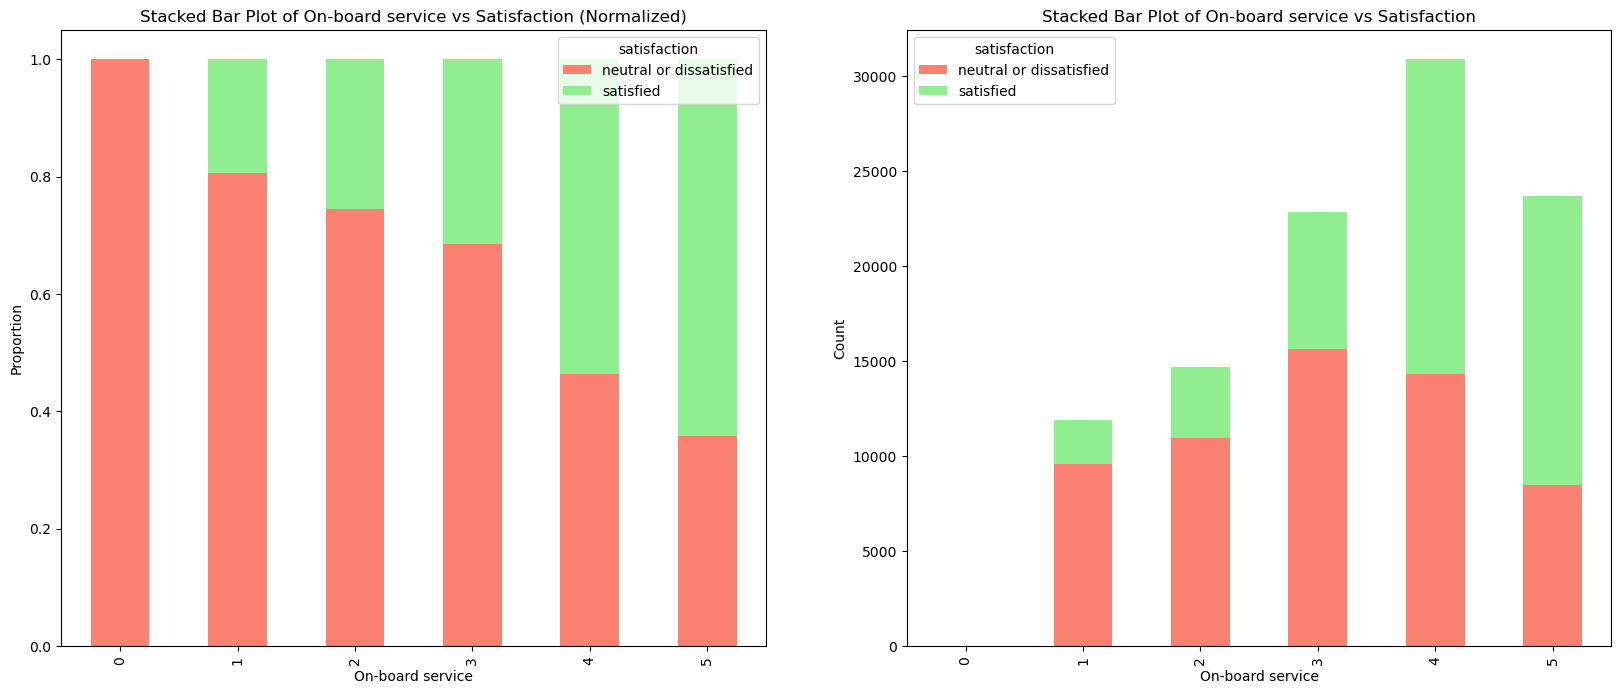

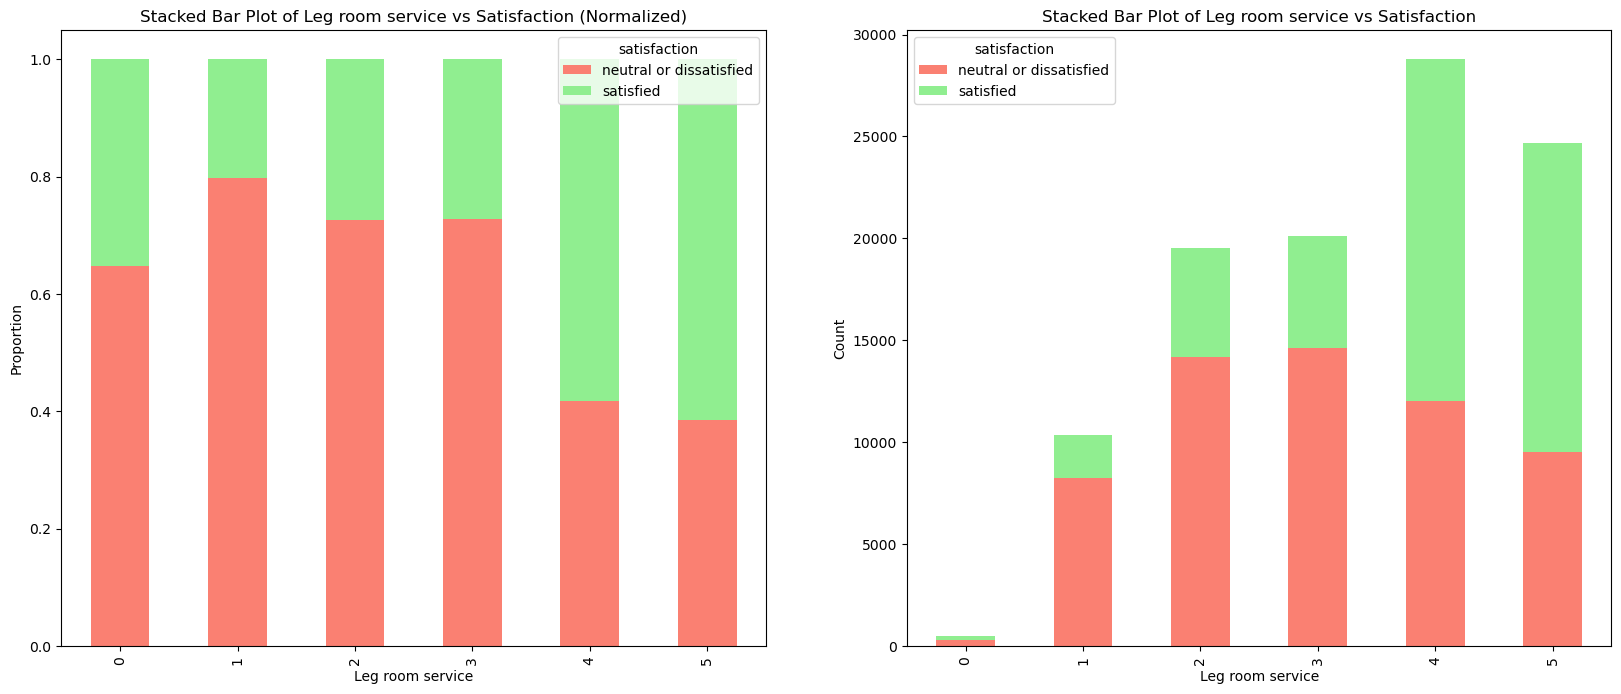

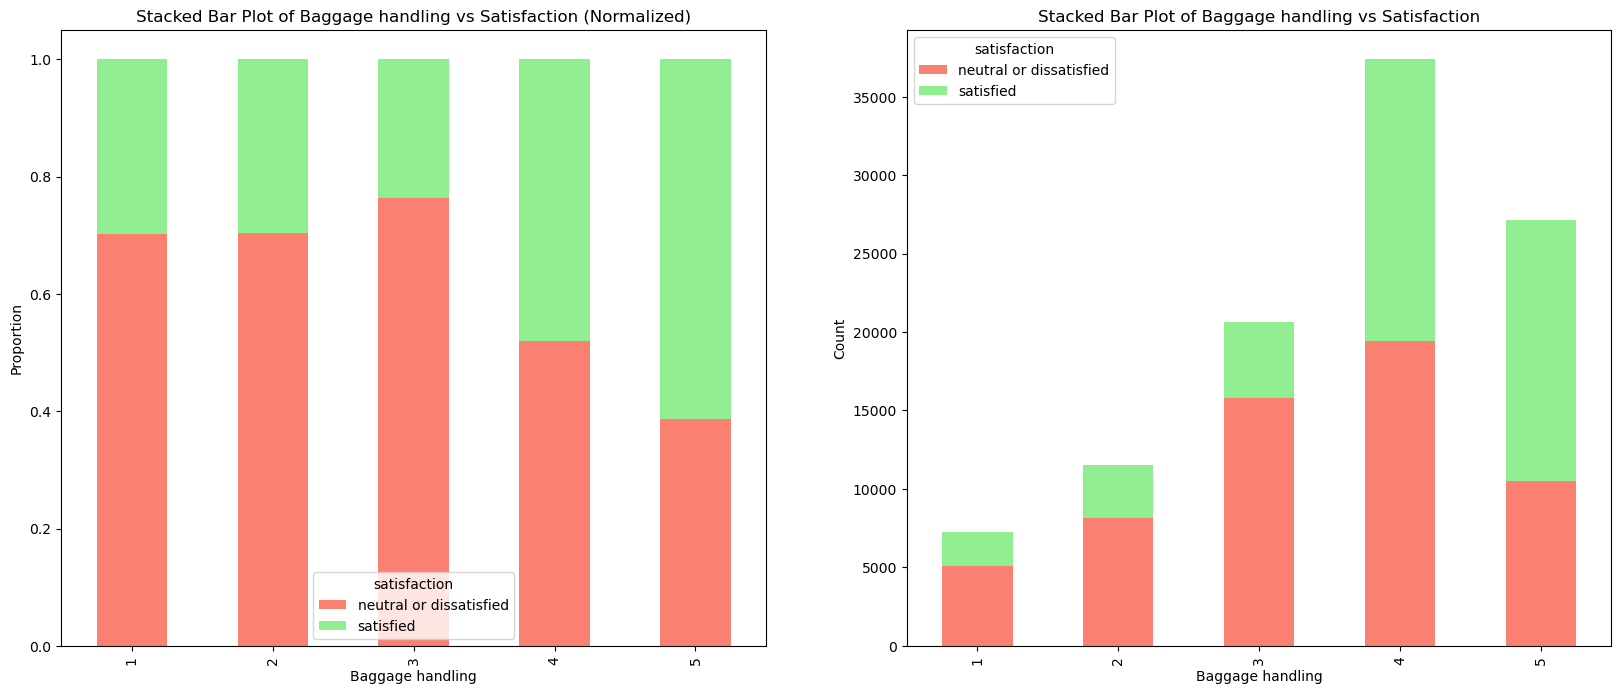

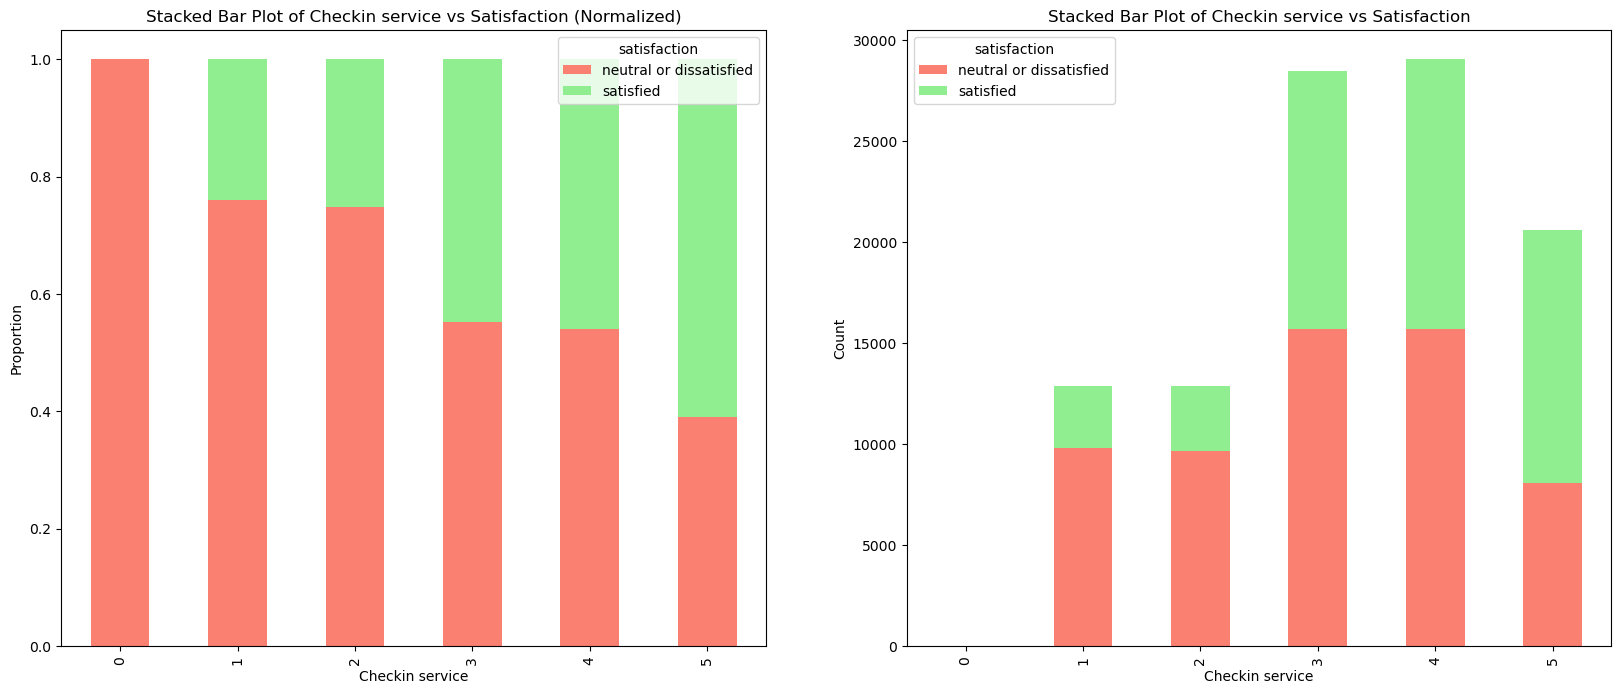

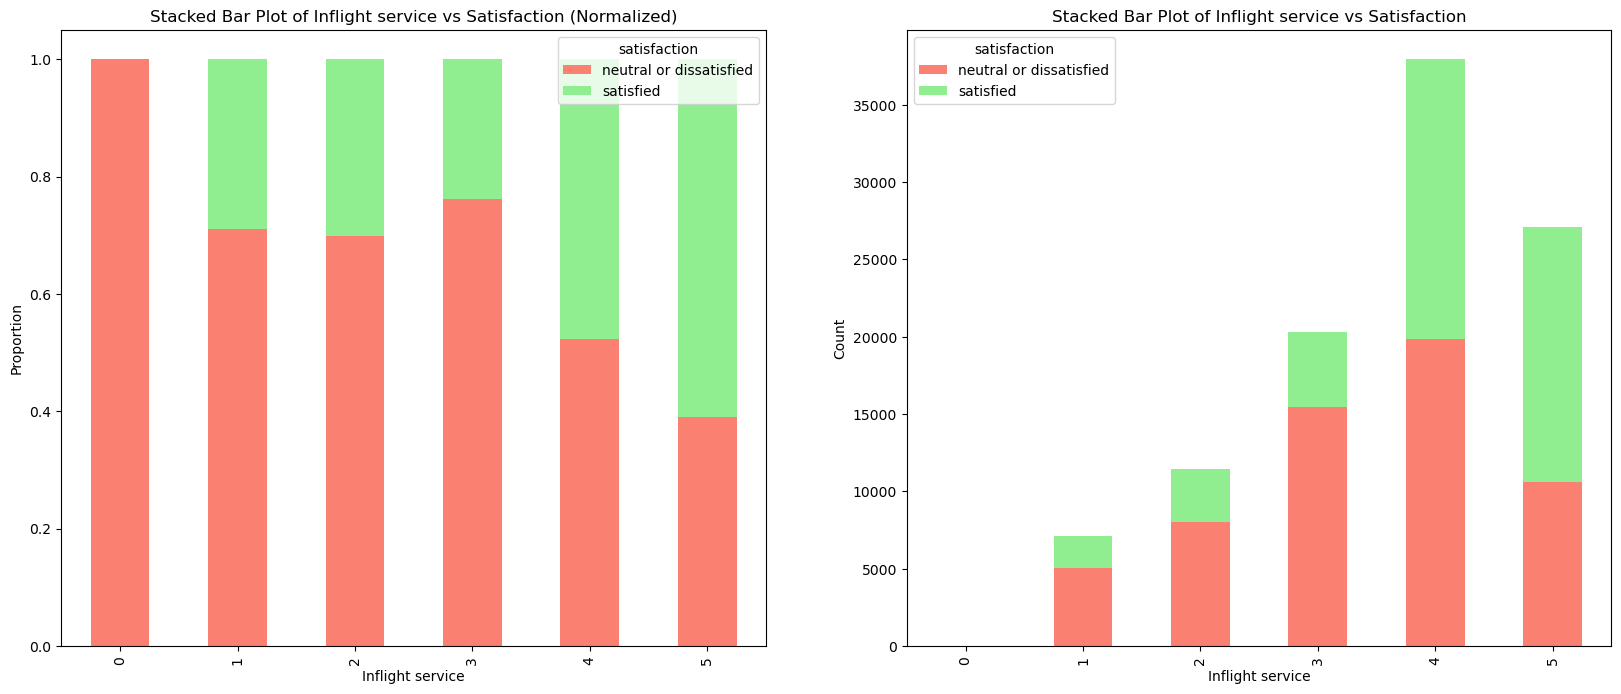

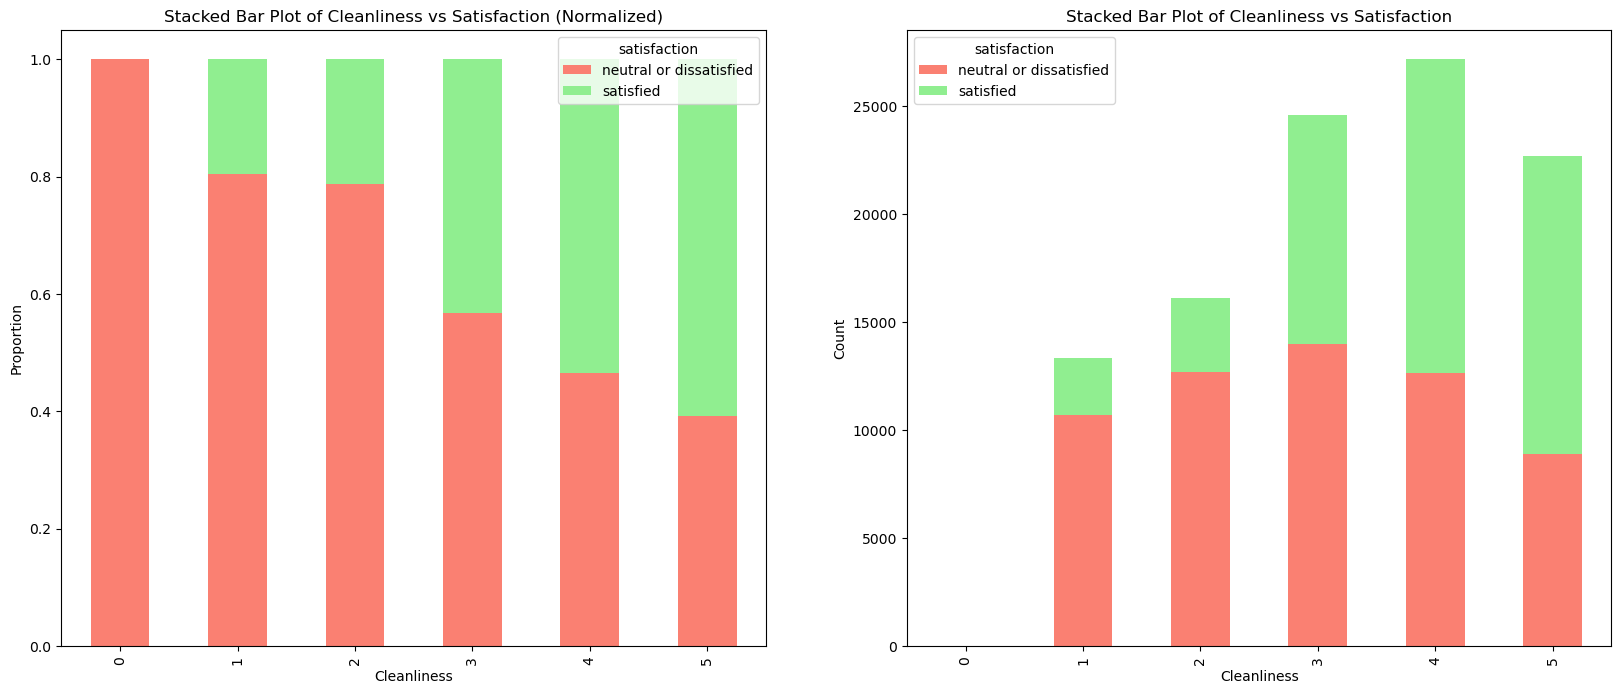

In [19]:
for i in categorical_X:


    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    
    cross_tab = pd.crosstab(train[i], train['satisfaction'])
    
    
    cross_tab_normalized = cross_tab.div(cross_tab.sum(1), axis=0)
    cross_tab_normalized.plot(kind='bar', stacked=True, ax=axes[0], color=['salmon', 'lightgreen'])
    axes[0].set_title(f'Stacked Bar Plot of {i} vs Satisfaction (Normalized)')
    axes[0].set_xlabel(i)
    axes[0].set_ylabel('Proportion')

    

    cross_tab.plot(kind='bar', stacked=True, ax=axes[1], color=['salmon', 'lightgreen'])
    axes[1].set_title(f'Stacked Bar Plot of {i} vs Satisfaction')
    axes[1].set_xlabel(i)
    axes[1].set_ylabel('Count')

    
    
    plt.show()

**Some variables, from a graphical point of view, don't seem are related to "satisfaction"; for some of these (like "Gender") this result is the expected one whilst for others (like "Departure/Arrival time convenient") it is not the expected one.**<br>
**Other variables, with a different intensity, seem have some kind of relationship with "satisfaction"; for some of these (like variables express satisfaction level) this result is the expected one whilst for others (like "Type of Travel") it is not the expected one. In any case none of the variables appear to have perfect predictive power regarding satisfaction; it will be necessary to consider combinations of multiple variables.**<br><br>
**Let's return to the discussion about variables that express satisfaction.**<br>
**If the value 0 was linked to a high dissatisfaction with the service to which it refers we would expect this to have negative consequences on the "satisfaction" variable. If this consequence were missing it could be that there is no correlation between the observed variable and the satisfaction variable or there could be an encoding problem.**<br>
**We consider the variables with a higher presence of 0 values in order to give statistical significance to our conclusions; these variables are "Inflight wifi service", "Ease of Online booking" and "Online boarding" ("Departure/Arrival time convenient" can be excluded given that we have already seen how this variable doesn't seem related to "satisfaction").**
**If we concentrated our attention on the values 1-5 of these variables we would notice that, more or less, as the values increase the proportion of satisfied subjects increases showing a partial correlation. If we observe the 0 values instead in some variables there is a strong proportion of satisfied people. The emblematic variable is "Inflight wifi service". This result leads us to lean towards the idea of ​​incorrect encoding.**

In [20]:
# With the chi-square test we can verify presence of correlation between categorical variables. In this way, we rely on a precise statistical test that goes beyond graphical intuitions

# The null hypothesis (Ho) is that the two variables are independet 
# The alternative hypothesis (H1) is that the two variables are not independent

chi_square_test(train[categorical_X ], train["satisfaction"])

# All the categorical variables seem correlated with "satisfaction"

Reject the null hypothesis for Gender. The variables are not independent.
Reject the null hypothesis for Customer Type. The variables are not independent.
Reject the null hypothesis for Type of Travel. The variables are not independent.
Reject the null hypothesis for Class. The variables are not independent.
Reject the null hypothesis for Inflight wifi service. The variables are not independent.
Reject the null hypothesis for Departure/Arrival time convenient. The variables are not independent.
Reject the null hypothesis for Ease of Online booking. The variables are not independent.
Reject the null hypothesis for Gate location. The variables are not independent.
Reject the null hypothesis for Food and drink. The variables are not independent.
Reject the null hypothesis for Online boarding. The variables are not independent.
Reject the null hypothesis for Seat comfort. The variables are not independent.
Reject the null hypothesis for Inflight entertainment. The variables are not indepen

*The chi_square test is based on two assumptions:*<br>
*1) The two variables should be measured at an ordinal or nominal level (i.e. categorical data);*<br>
*2) The two variables should consist of two or more categorical, independent groups;*<br>

Both assumptions are satisfied

**In this subsection we try to conduct some tests (and evaluate the consequences) regarding the treatment of "0" values ​​for categorical variables that express a level of satisfaction. We will try two approaches: the first consists of removing the rows in which these columns take on the value "0", while the second consists of performing a replacement of these values.**

### Removing rows with 0 values in the columns involved

In [21]:
# Let's verify in detail the correlation between all variables express satisfaction with 0 values and "satisfaction". In particular let's see what happens if we remove this rows
# In particular let's see if the correlation improve if for example we remove rows with 0 values

categorical_X_with_0_values = ["Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service", "Leg room service", "Checkin service", "Inflight service", "Cleanliness"]
train_with_nan = train[categorical_X_with_0_values].replace(0, np.nan)
chi_square_test_two_dataframes(train[categorical_X_with_0_values], train_with_nan, train["satisfaction"])

# The p-values and the values of the test statistic already in the presence of 0 values were quite good; in fact these values remained almost unchanged even after the elimination of these values

,column,chi2_df1,chi2_df2,p_df1,p_df2
0,Inflight wifi service,28696.409227,24816.150497,0.000000e+00,0.000000e+00
1,Departure/Arrival time convenient,451.062637,411.190777,2.897692e-95,1.062130e-87
2,Ease of Online booking,10407.606042,9447.848598,0.000000e+00,0.000000e+00
3,Gate location,2493.443647,2492.143320,0.000000e+00,0.000000e+00
4,Food and drink,5203.235820,5202.831770,0.000000e+00,0.000000e+00
5,Online boarding,39750.995604,39662.424162,0.000000e+00,0.000000e+00
6,Seat comfort,15756.130079,15755.329689,0.000000e+00,0.000000e+00
7,Inflight entertainment,18508.067998,18496.774461,0.000000e+00,0.000000e+00
8,On-board service,11508.560624,11506.188282,0.000000e+00,0.000000e+00
9,Leg room service,12271.369227,12256.027683,0.000000e+00,0.000000e+00


In [22]:
# Let's see if eliminating Nan values (which derive from the values 0) we obtain a small proportion of outliers

no_categorical_X_with_0_values = ["Gender", "Customer Type", "Age", "Type of Travel", "Class", "Flight Distance", "Baggage handling", "Departure Delay in Minutes", "Arrival Delay in Minutes"]
series = [X_train[col] for col in no_categorical_X_with_0_values]
X_train_2 = pd.concat([train_with_nan] + series, axis=1)

iforest = IsolationForest(random_state=42, n_jobs=-1)
prediction = iforest.fit_predict(X_train_2.dropna())

n_outliers = (prediction == -1).sum()
n_normals = (prediction == 1).sum()

print("Number of outliers detected: {} and their proportion is {}".format(n_outliers, round(n_outliers/len(X_train_2.dropna()),2)))
print("Number of normal samples detected: {} and their proportion is {}".format(n_normals, round(n_normals/len(X_train_2.dropna()),2)))

# The proportion has worsened compared to before (0.46/0.54)

Number of outliers detected: 48583 and their proportion is 0.51
Number of normal samples detected: 47121 and their proportion is 0.49


In [23]:
# Let's see if eliminating Nan values (which derive from the values 0) we obtain better performance respect to baseline models

test_with_nan = test[categorical_X_with_0_values].replace(0, np.nan)
series = [X_test[col] for col in no_categorical_X_with_0_values]
X_test_2 = pd.concat([test_with_nan] + series, axis=1)

y_train, y_test = y_train.to_frame(name='satisfaction'), y_test.to_frame(name='satisfaction') 
 
train_2_with_nan, test_2_with_nan = pd.concat([X_train_2, y_train], axis=1), pd.concat([X_test_2, y_test], axis=1)

train_2_no_nan, test_2_no_nan = train_2_with_nan.dropna(), test_2_with_nan.dropna()



rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(train_2_no_nan.drop(["satisfaction"], axis=1), train_2_no_nan.satisfaction)
print("Accuracy on the test set using Random Forest is:", rf.score(test_2_no_nan.drop(["satisfaction"], axis=1), test_2_no_nan.satisfaction))

ab = AdaBoostClassifier(random_state=42)
ab.fit(train_2_no_nan.drop(["satisfaction"], axis=1), train_2_no_nan.satisfaction)
print("Accuracy on the test set using AdaBoost is:", ab.score(test_2_no_nan.drop(["satisfaction"], axis=1), test_2_no_nan.satisfaction))

et = ExtraTreesClassifier(random_state=42, n_jobs=-1)
et.fit(train_2_no_nan.drop(["satisfaction"], axis=1), train_2_no_nan.satisfaction)
print("Accuracy on the test set using ExtraTreesClassifier is:", et.score(test_2_no_nan.drop(["satisfaction"], axis=1), test_2_no_nan.satisfaction))

# Performances are not improved, in fact they have gotten slightly worse

Accuracy on the test set using Random Forest is: 0.9624104261827935
Accuracy on the test set using AdaBoost is: 0.9256170640740896
Accuracy on the test set using ExtraTreesClassifier is: 0.961195155680342


**The results obtained from the correlation analysis and the outliers analysis leave me a little perplexed.**<br> 
**I thought that removing rows with NaN values improved the correlation (in reality there was already a very low p-value) but instead the values of the test statistic have (slightly) worsened. Furthermore, this approach did not improve neither the proportion of outliers (on the contrary it worsened slightly) nor the performances of the three models (on the contrary it worsened slightly).**<br><br>

**In any case, for me, the analyzes conducted at the beginning on these 0 values allow me to state that there is an encoding problem that needs to be treated.**

### Apply KNN imputer in the columns involved

In [24]:
# Let's verify in detail the correlation between all variables express satisfaction with 0 values and "satisfaction". In particular let's see what happens if we apply the knn imputer with default values for hyperparameters


imputer = KNNImputer(n_neighbors=5)
X_train_imputer = imputer.fit_transform(train_2_with_nan.drop(["satisfaction"], axis=1))
X_train_imputer = pd.DataFrame(data=X_train_imputer, columns=train_2_with_nan.drop(["satisfaction"], axis=1).columns)
for col in categorical_X_with_0_values:
    X_train_imputer[col] = X_train_imputer[col].round(0)
    
X_test_imputer = imputer.transform(test_2_with_nan.drop(["satisfaction"], axis=1))
X_test_imputer = pd.DataFrame(data=X_test_imputer, columns=test_2_with_nan.drop(["satisfaction"], axis=1).columns)
for col in categorical_X_with_0_values:
    X_test_imputer[col] = X_test_imputer[col].round(0)


In [25]:
# In particular let's see if the correlation improve if for example we use KNN imputer

chi_square_test_two_dataframes(train[categorical_X_with_0_values], X_train_imputer[categorical_X_with_0_values], train["satisfaction"])

# The p-values and the values of the test statistic already in the presence of 0 values were quite good; in fact these values remained almost unchanged even after the use of KNN imputer

,column,chi2_df1,chi2_df2,p_df1,p_df2
0,Inflight wifi service,28696.409227,22685.194204,0.000000e+00,0.000000e+00
1,Departure/Arrival time convenient,451.062637,339.274713,2.897692e-95,3.626655e-72
2,Ease of Online booking,10407.606042,8724.815394,0.000000e+00,0.000000e+00
3,Gate location,2493.443647,2491.708276,0.000000e+00,0.000000e+00
4,Food and drink,5203.235820,5204.836931,0.000000e+00,0.000000e+00
5,Online boarding,39750.995604,38492.626549,0.000000e+00,0.000000e+00
6,Seat comfort,15756.130079,15755.947848,0.000000e+00,0.000000e+00
7,Inflight entertainment,18508.067998,18499.561308,0.000000e+00,0.000000e+00
8,On-board service,11508.560624,11505.807544,0.000000e+00,0.000000e+00
9,Leg room service,12271.369227,12212.018154,0.000000e+00,0.000000e+00


In [26]:
# Let's see if using KNN imputer we obtain a small proportion of outliers

iforest = IsolationForest(random_state=42, n_jobs=-1)
prediction = iforest.fit_predict(X_train_imputer)

n_outliers = (prediction == -1).sum()
n_normals = (prediction == 1).sum()

print("Number of outliers detected: {} and their proportion is {}".format(n_outliers, round(n_outliers/len(X_train_imputer), 2)))
print("Number of normal samples detected: {} and their proportion is {}".format(n_normals, round(n_normals/len(X_train_imputer), 2)))

# The proportion has worsened compared to before (0.46/0.54). It is worsened also compared to the approach of removing 0 values (0.51/0.49)

Number of outliers detected: 57433 and their proportion is 0.55
Number of normal samples detected: 46471 and their proportion is 0.45


In [27]:
# Let's see if using we obtain better performance respect to baseline models

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_imputer, y_train.satisfaction)
print("Accuracy on the test set using Random Forest is:", rf.score(X_test_imputer, y_test.satisfaction))

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train_imputer, y_train.satisfaction)
print("Accuracy on the test set using AdaBoost is:", ab.score(X_test_imputer, y_test.satisfaction))

et = ExtraTreesClassifier(random_state=42, n_jobs=-1)
et.fit(X_train_imputer, y_train.satisfaction)
print("Accuracy on the test set using ExtraTreesClassifier is:", et.score(X_test_imputer, y_test.satisfaction))

# Performances are not improved, in fact they have gotten slightly worse. They are worsened also compared to the approach of removing 0 values

Accuracy on the test set using Random Forest is: 0.9503387742531567
Accuracy on the test set using AdaBoost is: 0.906298121342778
Accuracy on the test set using ExtraTreesClassifier is: 0.9482599322451494


**In summary, even the knn imputer approach (with standard values for the hyperparameters) does not improve the results in terms of correlation, outliers and performances. However, I continue to believe that there is an encoding error.**

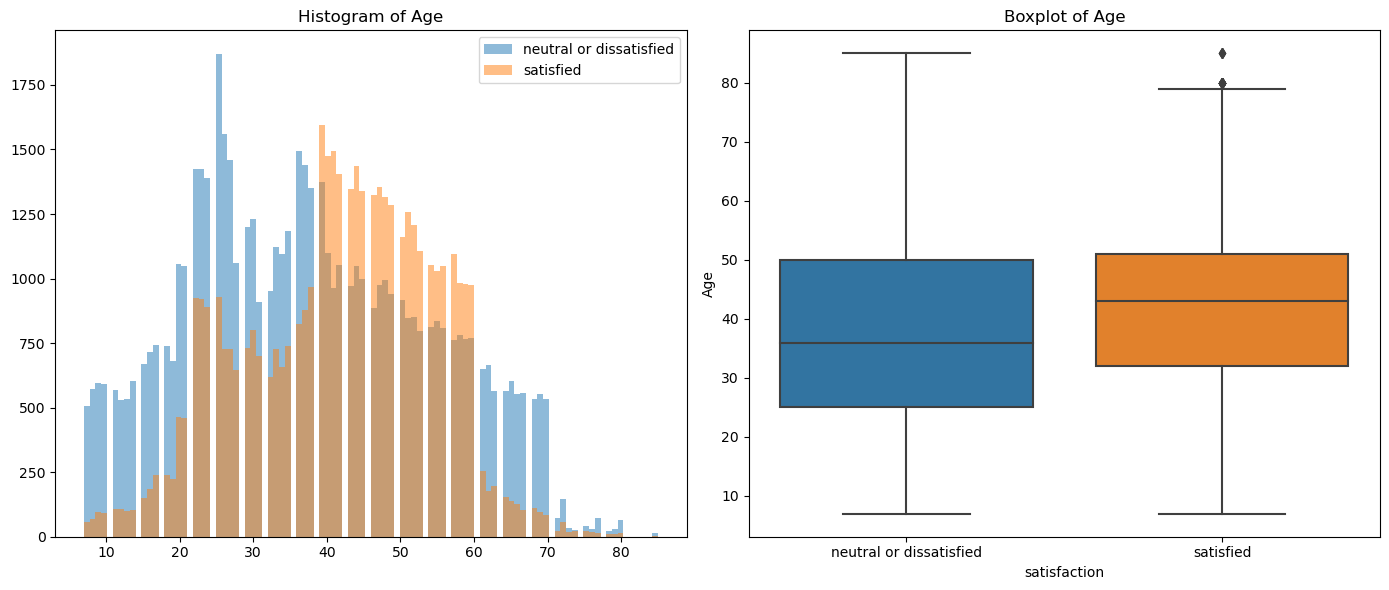

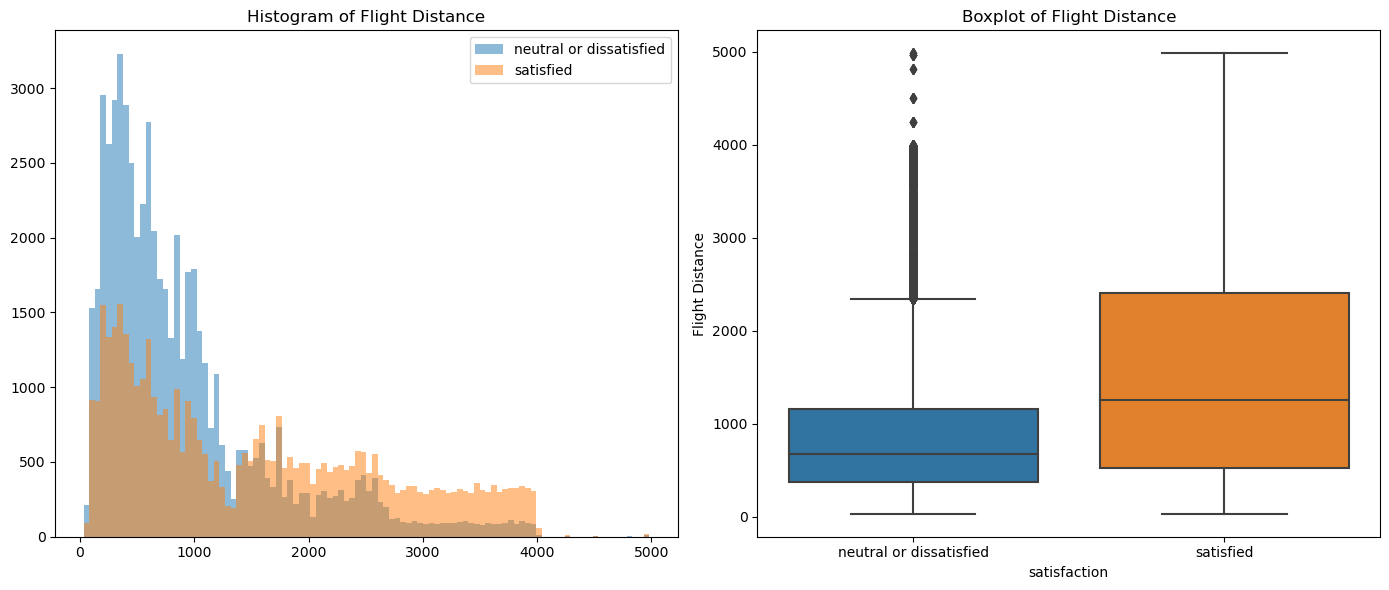

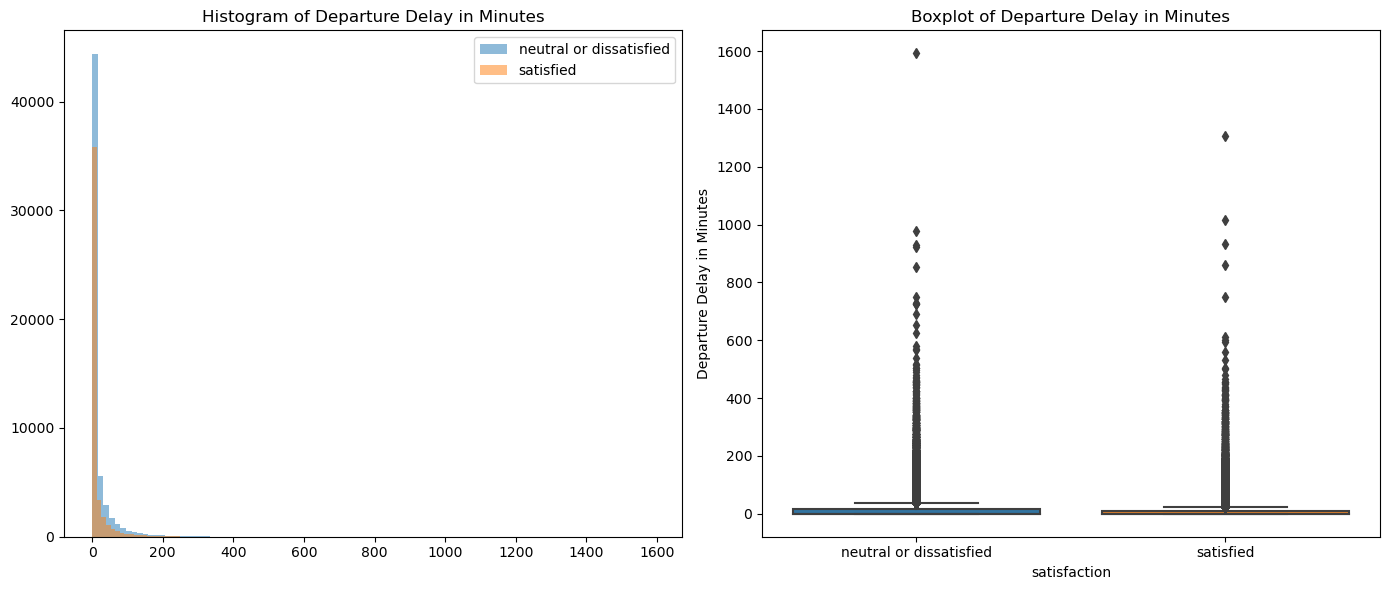

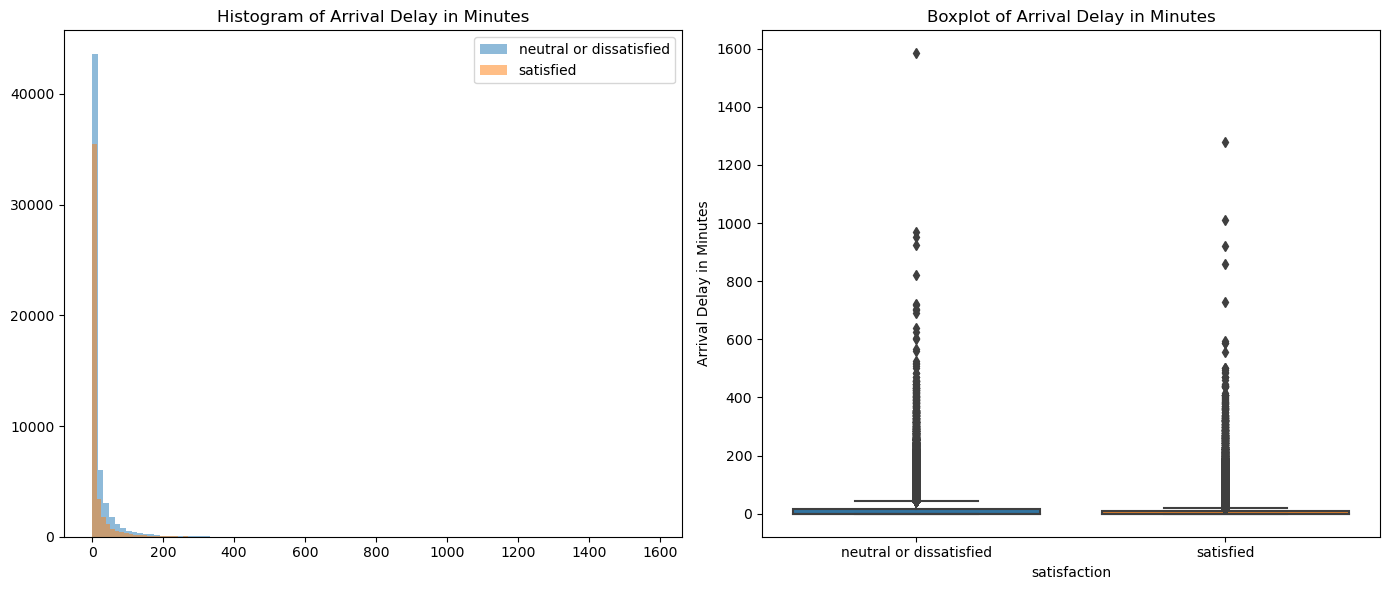

In [28]:
for i in ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Istogramma per la classe "neutral or dissatisfied"
    axes[0].hist(train[train["satisfaction"]=="neutral or dissatisfied"][i], label='neutral or dissatisfied', bins=100, alpha=0.5)
    axes[0].hist(train[train["satisfaction"]=="satisfied"][i], label='satisfied', bins=100, alpha=0.5)
    axes[0].set_title(f'Histogram of {i}')
    axes[0].legend(loc='upper right')
    
    # Boxplot separato per la classe satisfaction
    sns.boxplot(x='satisfaction', y=i, data=train, ax=axes[1])
    axes[1].set_title(f'Boxplot of {i}')
    
    plt.tight_layout()
    plt.show()

**Passengers with Age<40 and Age>60 are, in general, more neutral/dissatisfied than satisfied; passengers with 40<Age<60 are, in general, more satisfied than neutral/dissatisfied. Passengers with Flight Distance experience<1500 are, in general, more neutral/dissatisfied than satisfied; passengers with Flight Distance experience>1500 are, in general more satisfied than neutral/dissatisfied; in addition hight values for neutral or dissatisfied seem are outliers.** <br>
**There isn't a strong relationship between "Departure Delay in Minutes" or "Arrival Delay in Minutes" and "satisfaction".**

In [29]:
# With the one-way ANOVA test we can verify presence of correlation between numerical variable and categorical variable

# The null hypothesis (Ho) is that there is not a significant difference in mean 
# The alternative hypothesis (H1) is that there is a significant difference in mean

anova_correlation(train[["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]], le.fit_transform(train["satisfaction"]))

# All numerical variables seems be are correlated with "satisfaction" variable

Reject the null hypothesis for column Age. There is a significant difference in means.
Reject the null hypothesis for column Flight Distance. There is a significant difference in means.
Reject the null hypothesis for column Departure Delay in Minutes. There is a significant difference in means.
Reject the null hypothesis for column Arrival Delay in Minutes. There is a significant difference in means.


*The one-way ANOVA tests is based on three assumptions:*<br>
*1) The samples are independent;*<br>
*2) Each sample is from a normally distributed population;*<br>
*3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.*<br>

The first assumption is satisfied, for the second assumption we can do the Shapiro-Wilk test; for the third assumption we can do the Levene test

In [30]:
# Let's check if variables passe the Shapiro-Wilk test
# The null hypothesis (Ho) is that variable is normally distributed 
# The alternative hypothesis (H1) is that variable is not normally distributed 

print(shapiro_wilk_test(train[["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]]))

# The Shapiro-Wilk test was not passed by any variable

print("\n\n")

# Let's check if variables passe the Levene test
# The null hypothesis (Ho) is that Homoschedasticity is met 
# The alternative hypothesis (H1) is that Homoschedasticity is violated

print(check_homoscedasticity(train[["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]], train["satisfaction"]))


# The Levene test was not passed by any variable

# Since not all the assumptions are satisfied, the correlation coefficient (at least for these four variables) is not reliable

Reject the null hypothesis for column Age. The variable is not normally distributed.
Reject the null hypothesis for column Flight Distance. The variable is not normally distributed.
Reject the null hypothesis for column Departure Delay in Minutes. The variable is not normally distributed.
Reject the null hypothesis for column Arrival Delay in Minutes. The variable is not normally distributed.
None



Reject the null hypothesis for Age. Homoscedasticity assumption is violated.
Reject the null hypothesis for Flight Distance. Homoscedasticity assumption is violated.
Reject the null hypothesis for Departure Delay in Minutes. Homoscedasticity assumption is violated.
Reject the null hypothesis for Arrival Delay in Minutes. Homoscedasticity assumption is violated.
None


C:\Users\giaco\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## BIVARIATE (AND MULTIVARIATE) ANALYSIS (numerical-numerical features, find multicollinearity)
**The bivariate (and multivariate) approach aims to analyze more than one variable at the same time; in this step we analyze each variable in relation to the others let's see if we can obtain some interesting information.**

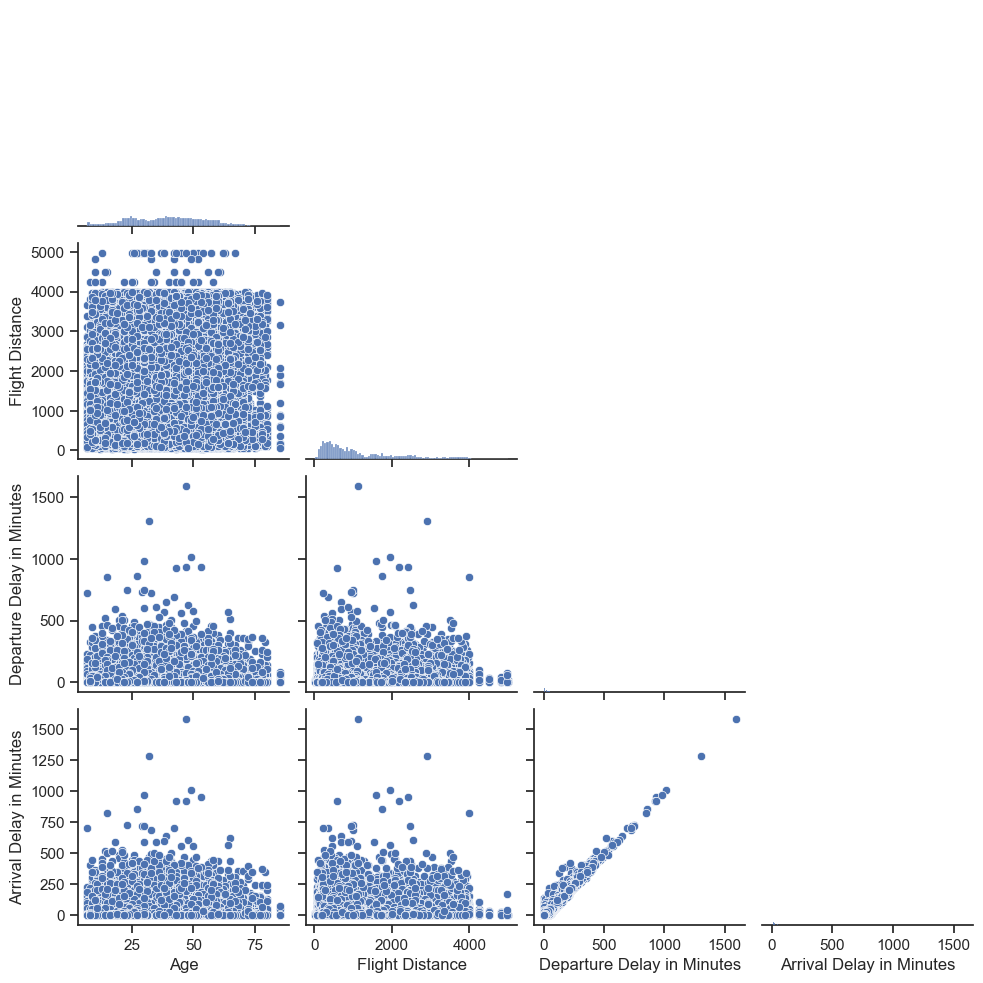

In [31]:
sns.set(style="ticks")
sns.pairplot(train, corner=True)
plt.show()

**There appears to be no correlation between variables, except for "Arrival Delay in Minutes" and "Departure Delay in Minutes"; in this case there is multicollinearity (linear correlation).**
**Linear correlation between features can negatively affect specific models; in particular for linear models multicollinearity can yield solutions that are wildly varying and possibly numerically unstable. In that case we need to eliminate multicollinearity (i.e. removing one feature). The predictive power of the three models we have chosen, in general, is not negatively affected  by multicollinearity given that they aren't linear models; however a strong linear correlation can be defined as a redundant information and it can negatively affect the efficiency of all models; since we have seen that both variables are correlated with "satisfaction" (although not all the assumptions of the test are satisfied) we decide to keep both variables.**

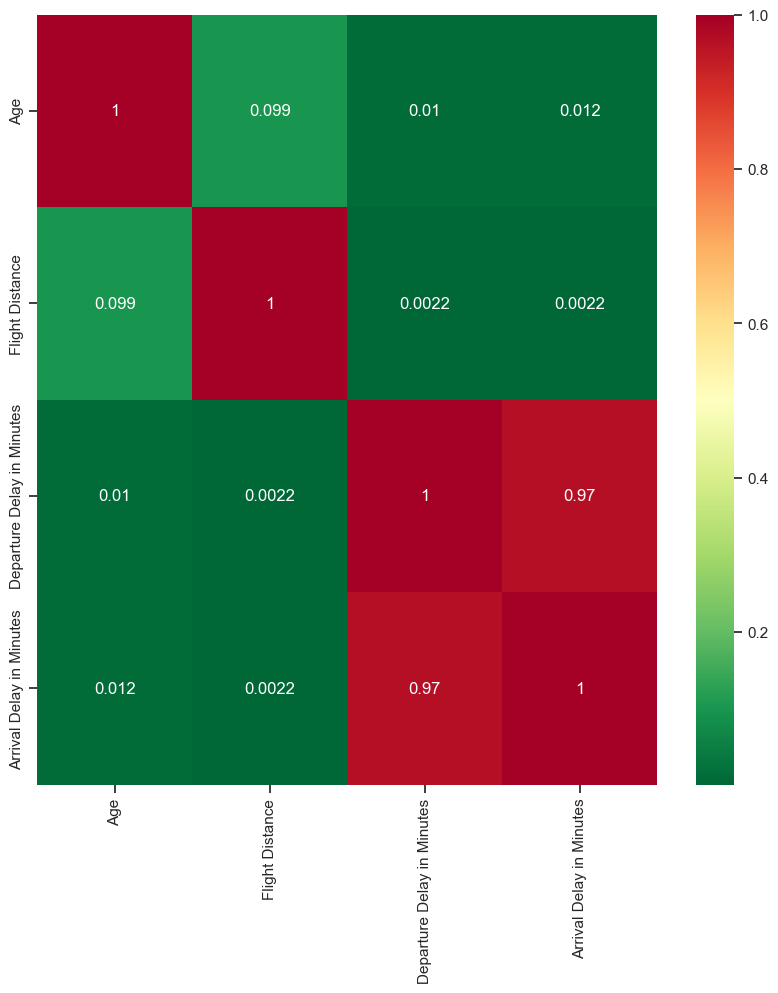

In [32]:
# Let's verify correlation between numerical features using the Pearson Correlation

plt.figure(figsize=(10, 10))
sns.heatmap(train.corr().abs(), cmap="RdYlGn_r", annot=True)
plt.show()

**Correlation matrix (based on Pearson Correlation matrix) confirms multicollinearity between "Departure Delay in Minutes" and "Arrival Delay in Minutes"**.

*The Pearson Correlation Coefficient is based on three assumptions:*<br>
*1) The two variables need to be using a continuous scale;*<br>
*2) There should be no outliers;*<br>
*3) The variables should be normally or near-to-normally distributed.*<br>

The first assumption is satisfied by all variables, the second assumption is satisfied by only "Age" (see boxplot); the third assumption is not satisfied by any variable (see the Shapiro-Wilk test)

Since not all the assumptions are satisfied, the correlation coefficient (at least for these four variables) is not reliable

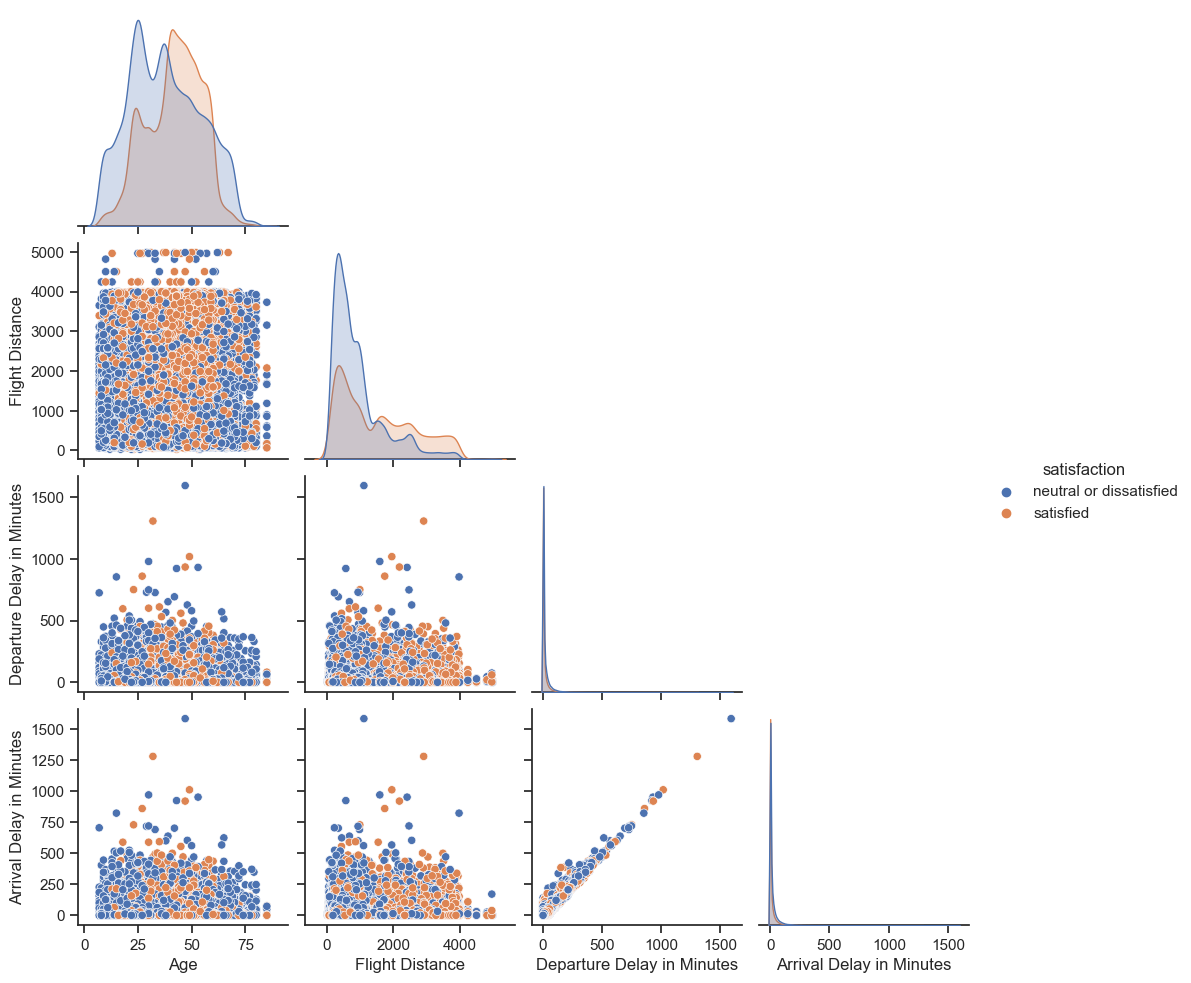

In [33]:
sns.set(style="ticks")
sns.pairplot(train, corner=True, hue="satisfaction")
plt.show()

**Pairwise continuous variables seems aren't able to separate "satisfaction."**

# PRE-PROCESSING

In [34]:
# Let's return to the problem of categorical variables express satisfaction
# Considering the desire to "treat" these variables, the approach that seemed most painless was to remove the rows with values ​​of 0

# Let's have a look to the composition of the dataset related to 0 values for columns express satisfaction if we transform 0 in NaN

train[categorical_X_with_0_values] = train[categorical_X_with_0_values].replace(0, np.nan)
test[categorical_X_with_0_values] = test[categorical_X_with_0_values].replace(0, np.nan)
print(find_missing_columns(train))
print("\n\n")
print(find_missing_columns(test))
print("\n\n")
print(count_nan_rows(train, "train set"))
print(count_nan_rows(test, "test set"))


Columns with missing values, their counts, and their proportions:
Inflight wifi service: 3103 missing values (2.99% of total rows)
Departure/Arrival time convenient: 5300 missing values (5.10% of total rows)
Ease of Online booking: 4487 missing values (4.32% of total rows)
Gate location: 1 missing values (0.00% of total rows)
Food and drink: 107 missing values (0.10% of total rows)
Online boarding: 2428 missing values (2.34% of total rows)
Seat comfort: 1 missing values (0.00% of total rows)
Inflight entertainment: 14 missing values (0.01% of total rows)
On-board service: 3 missing values (0.00% of total rows)
Leg room service: 472 missing values (0.45% of total rows)
Checkin service: 1 missing values (0.00% of total rows)
Inflight service: 3 missing values (0.00% of total rows)
Cleanliness: 12 missing values (0.01% of total rows)
None



Columns with missing values, their counts, and their proportions:
Inflight wifi service: 813 missing values (3.13% of total rows)
Departure/Arrival t

**The percentage of rows with NaN values allows us (even if we are at the limit) to removing these rows.**

In [35]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [36]:
train2 = train.copy()

# We apply LabelEncoder transformation to dicotomic variables

for column in ["Gender", "Customer Type", "Type of Travel"]:
    train2[column] = le.fit_transform(train2[column])
    
# We apply OrdinalEncoder to "Class" because ECO < ECO PLUS < BUSINESS. 

train2["Class"] = oe.fit_transform(train2[["Class"]])

**Let's verify what are the best features, i.e. the the variables that impact the target variable the most.**

In [37]:
print(select_k_best_features(chi2, train2, "satisfaction", k=10))
print("\n")
print(select_k_best_features(mutual_info_classif, train2, "satisfaction", k=10))
print("\n")
print(select_k_best_features(f_classif, train2, "satisfaction", k=10))

Selected 10 features using method chi2: ['Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
None


Selected 10 features using method mutual_info_classif: ['Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Cleanliness']
None


Selected 10 features using method f_classif: ['Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Cleanliness']
None


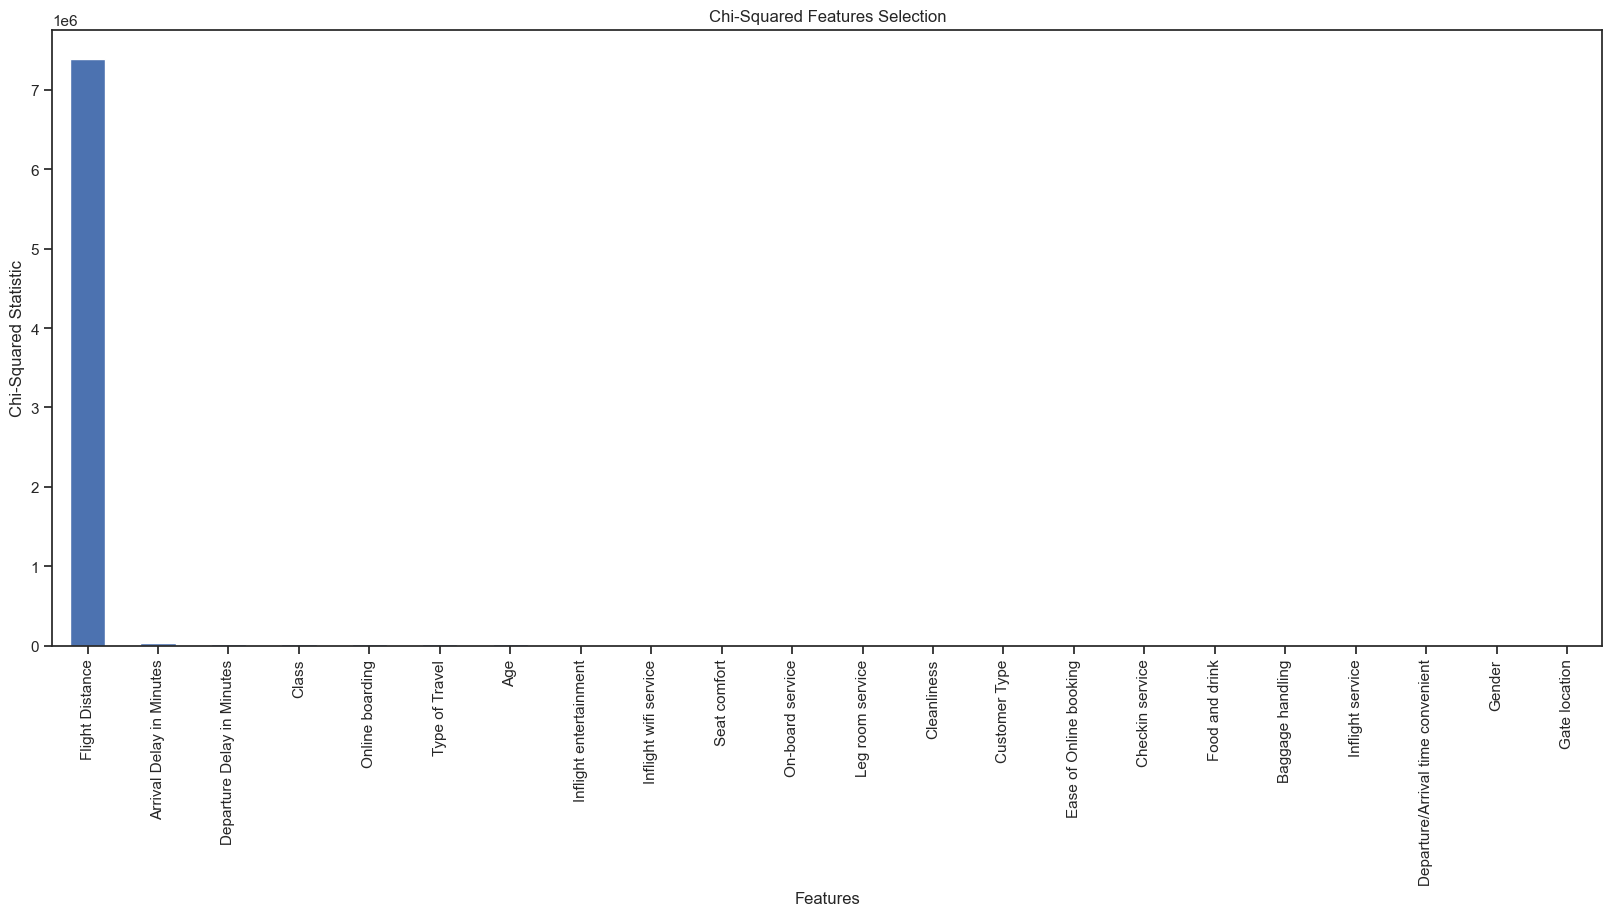

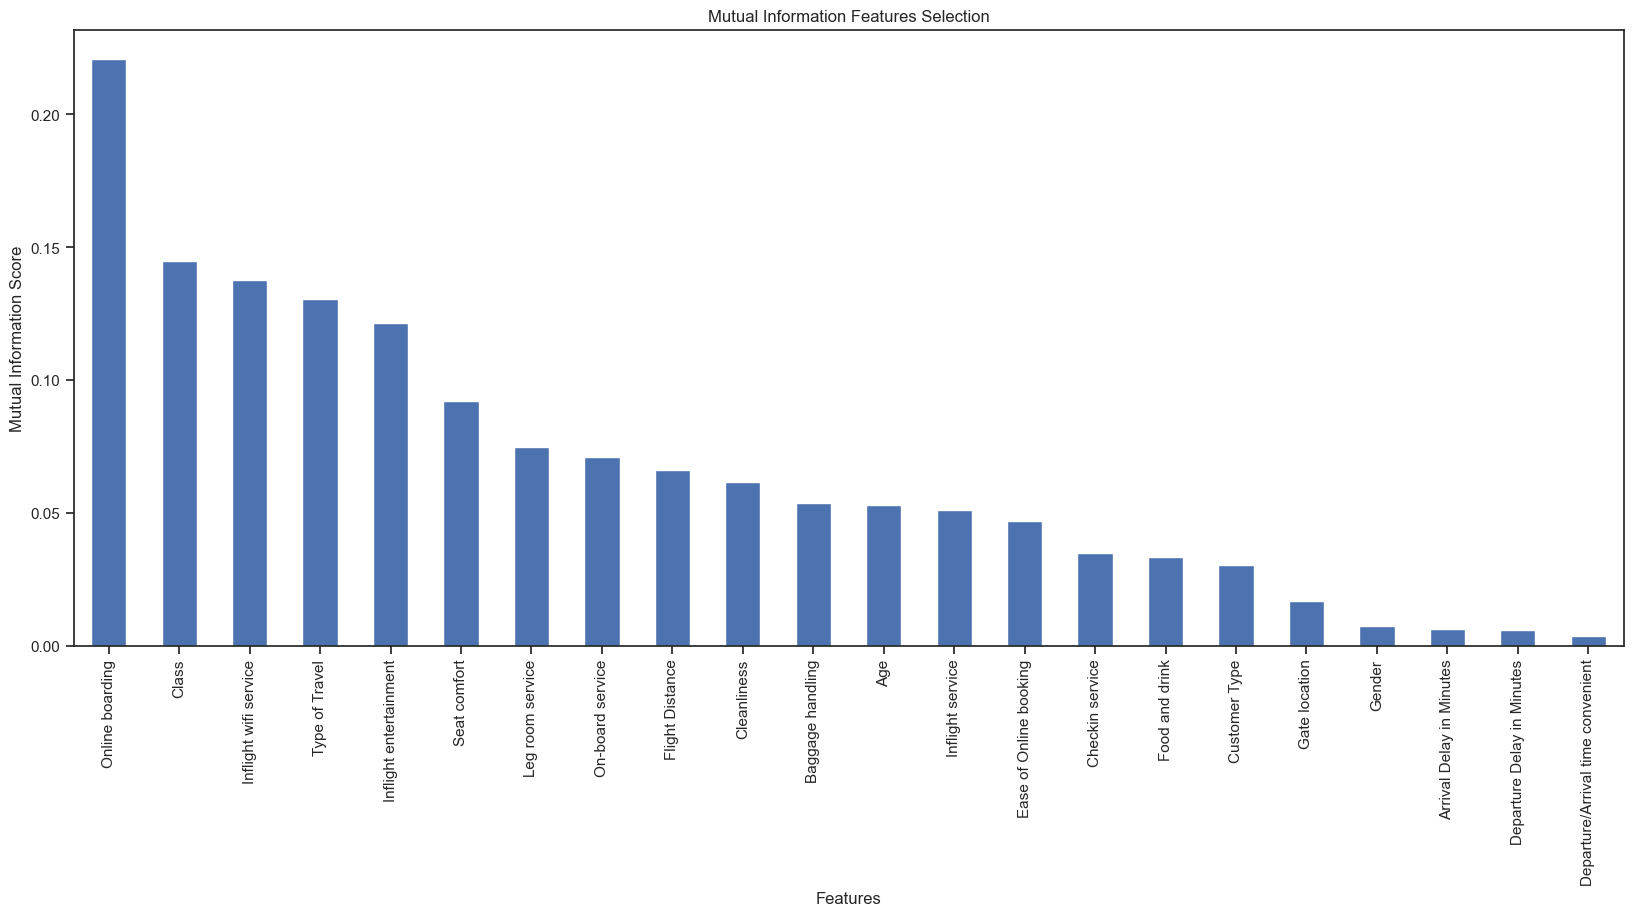

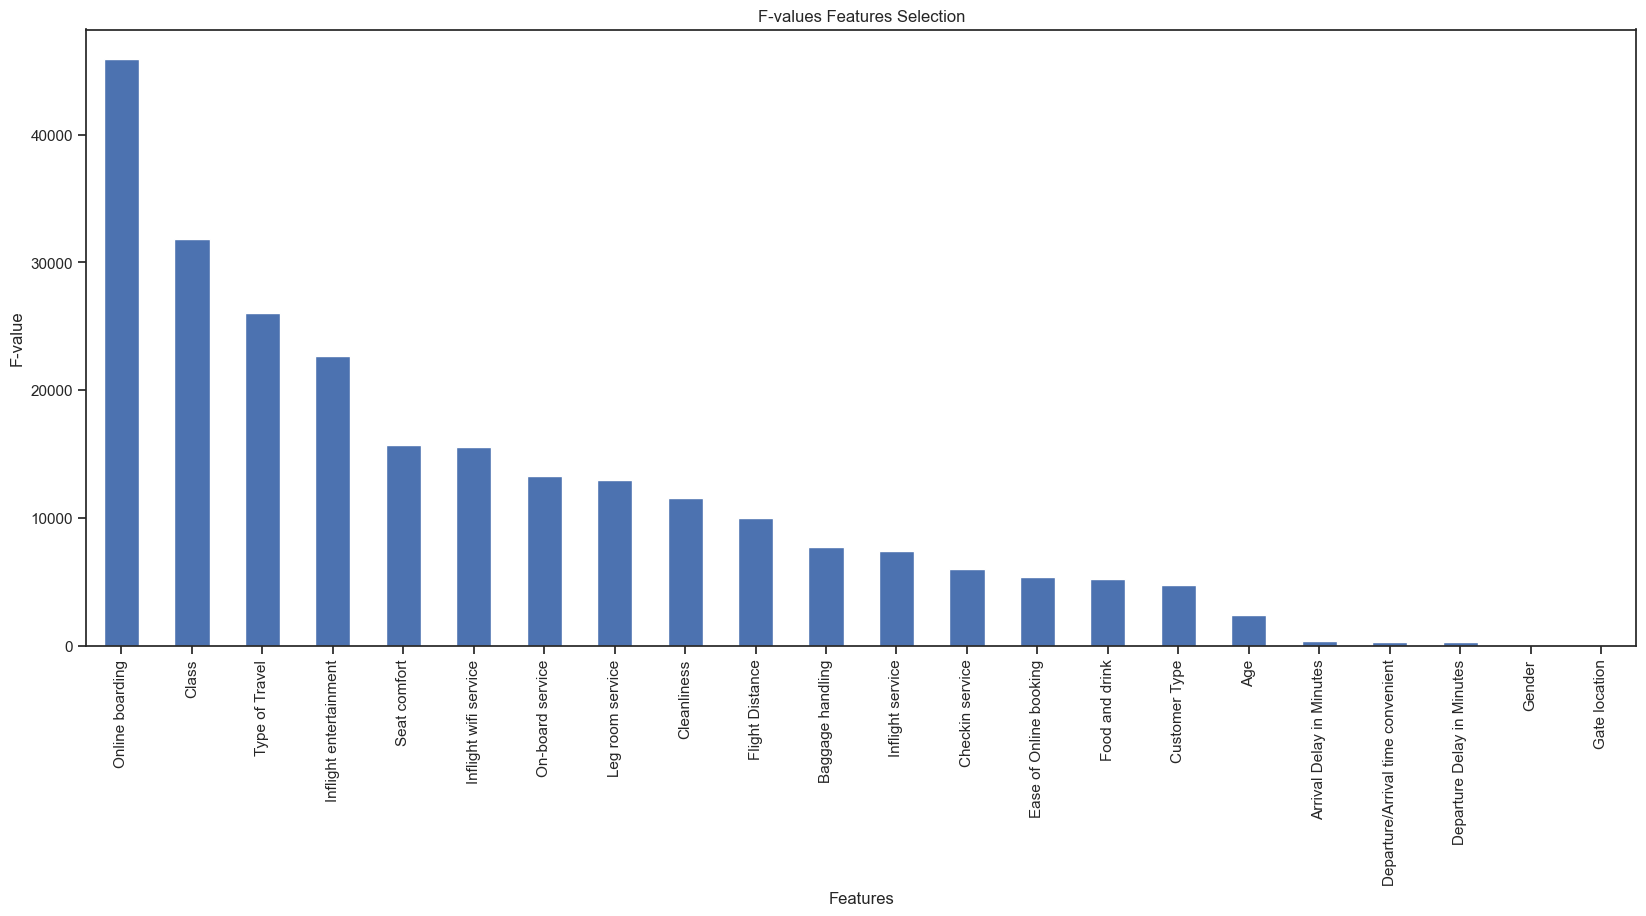

In [38]:
plot_chi_squared_selection_features(train2, "satisfaction")
plot_mutual_information_selection_features(train2, "satisfaction")
plot_f_values_selection_features(train2, "satisfaction")

**The project requires following two paths:**
1) considering all the variables;<br>
2) considering only the 3/4 most important variables based on the graphic analysis conducted previously.<br><br>


**The project requires that for each road it is necessary to select the two best models with a spot check using k-fold cross validation as the evaluation method.**

Defined 3 models
>ada: 0.926 (+/-0.002)
>rf: 0.961 (+/-0.002)
>et: 0.960 (+/-0.001)

Rank=1, Name=rf, Score=0.961 (+/- 0.002)
Rank=2, Name=et, Score=0.960 (+/- 0.001)


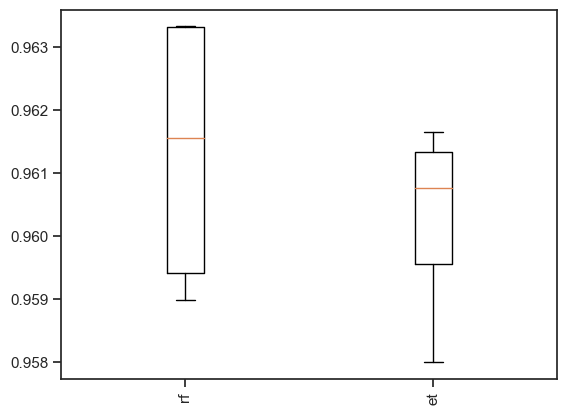

In [39]:
# Let's verify what are the two best models if all variables are considered

X_train_comp, y_train = train.drop("satisfaction", axis=1), train.satisfaction

results = evaluate_models(X_train_comp, y_train, define_models())

summarize_results(results)

# The best models are Random Forest and Extra Trees Classifier

Defined 3 models
>ada: 0.865 (+/-0.002)
>rf: 0.879 (+/-0.002)
>et: 0.879 (+/-0.002)

Rank=1, Name=et, Score=0.879 (+/- 0.002)
Rank=2, Name=rf, Score=0.879 (+/- 0.002)


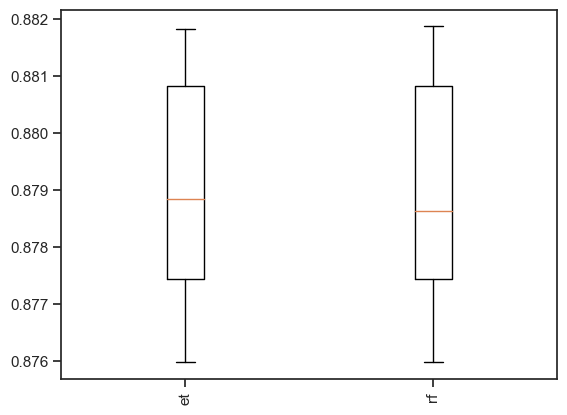

In [40]:
# Let's verify what are the two best models if only the 4 most important variables are considered, i.e. ['Type of Travel', 'Class', 'Online boarding', 'Inflight entertainment'] (see the three plot above)

X_train_redu = train[['Type of Travel', 'Class', 'Online boarding', 'Inflight entertainment']]

results = evaluate_models2(X_train_redu, y_train, define_models())

summarize_results(results)

# The best models are Extra Trees Classifier and Random Forest Classifier (in the same way)


In [41]:
X_test_comp, X_test_redu, y_test = test.drop("satisfaction", axis=1), test[['Type of Travel', 'Class', 'Online boarding', 'Inflight entertainment']], test.satisfaction

**The project requires to perform hyperparameter tuning on these two best models for each scenario, for example using a grid search and always cross validation as evaluation method.**

# HYPERPARAMETER TUNING

## We have 4 models to analyze:

1) RandomForestClassifier with X_train_comp;<br>
2) ExtraTreesClassifier with X_train_comp;<br>
3) RandomForestClassifier with X_train_redu;<br>
4) ExtraTreesClassifier with X_train_redu.


In [ ]:
print(hyper_tuning(X_train_comp, y_train, 'RandomForest', ["Gender", "Customer Type", "Type of Travel"]))
print(hyper_tuning(X_train_comp, y_train, 'ExtraTrees', ["Gender", "Customer Type", "Type of Travel"]))
print(hyper_tuning(X_train_redu, y_train, 'RandomForest', ["Type of Travel"]))
print(hyper_tuning(X_train_redu, y_train, 'ExtraTrees', ["Type of Travel"]))

# the best hyperparameters for RandomForest on X_train_comp are: 'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 150
# the accuracy is 0.9623108945073892

# the best hyperparameters for ExtraTrees on X_train_comp are: 'classifier__criterion': 'log_loss', 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 150
# the accuracy is 0.9612764548758956

# the best hyperparameters for RandomForest on X_train_redu are: 'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100
# the accuracy is 0.8789496748460266

# the best hyperparameters for ExtraTrees on X_train_redu are: 'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100
# the accuracy is 0.8789810233543219

*p.s: In this phase, within the cross validation, there is a small data leakage problem. In fact, although the encoding is contained within the pipeline, the missing values of "Arrival Delay in Minutes" were imputed by taking the entire train dataset; within the cross validation there is therefore a contamination between train and validation set.*

# BEST MODEL
**Among the 4 best models, the one that achieved the best results with hyperparameter tuning was the Random Forest Classifier associated with the complete dataset.**

In [42]:
# Pre-processing on X_train_comp and X_test_comp

# We apply LabelEncoder transformation to dicotomic variables
for column in ["Gender", "Customer Type", "Type of Travel"]:
    X_train_comp[column] = le.fit_transform(X_train_comp[column])
    X_test_comp[column] = le.transform(X_test_comp[column])
    
# We apply OrdinalEncoder to "Class" because ECO < ECO PLUS < BUSINESS 
order = ["Eco", "Eco Plus", "Business"]
oe = OrdinalEncoder(categories = [order])
X_train_comp["Class"] = oe.fit_transform(X_train_comp[["Class"]])
X_test_comp["Class"] = oe.transform(X_test_comp[["Class"]])

In [43]:
# Fitting on X_train_comp and Saving model

rf = RandomForestClassifier(random_state=42, n_jobs=-1, criterion="entropy", max_features="sqrt", min_samples_leaf=1, min_samples_split=4, n_estimators=150)
rf.fit(X_train_comp, y_train)
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)
    
# We can use app.py in order to make prediction

In [44]:
# Accuracy on test set

rf.score(X_test_comp, y_test)

# Accuracy with hyperparameter tuning has slightly improved with respect default values on the baseline model (0.962580843855867)

0.963248543770691

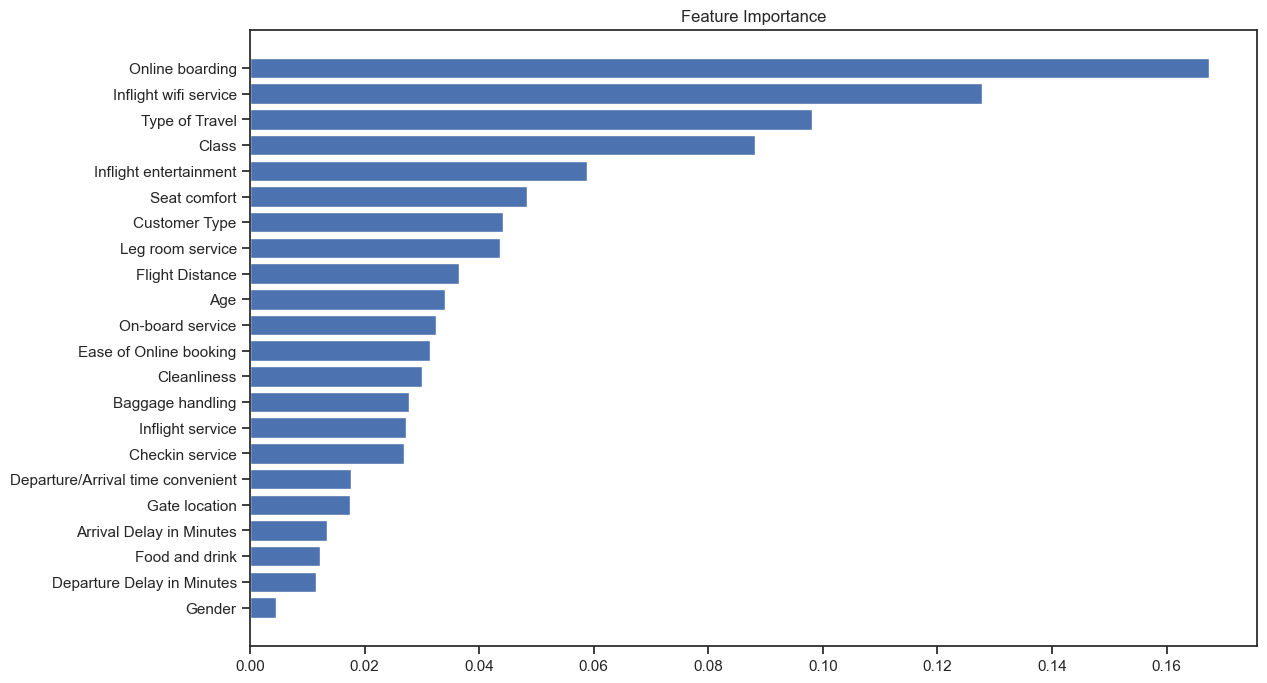

In [45]:
# Random Forest has its own attribute linked to feature importance. We can apply this in order to verify if there are differences with respect approaches used above

feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(13, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train_comp.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

# The results are similar to those obtained with the F-score and Mutual Information approach

# Error Analysis

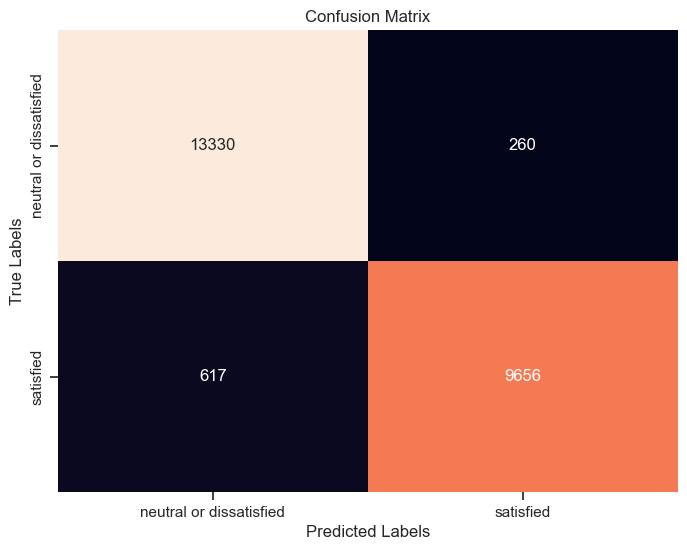

In [48]:
# We can analyze where model goes wrong

y_pred = rf.predict(X_test_comp)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
labels = ['neutral or dissatisfied', 'satisfied']
sns.heatmap(cm, annot=True, cbar=False, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# In general the model seems to be more wrong in predicting the "satisfied" class.
# Out of a total of 10273 passengers belonging to this class, 617 were in fact incorrectly classified as "neutral or dissatisfied"

In [50]:
# What we said can be proved by the classification report

report = classification_report(y_test, y_pred)
print(report)

                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     13590
              satisfied       0.97      0.94      0.96     10273

               accuracy                           0.96     23863
              macro avg       0.96      0.96      0.96     23863
           weighted avg       0.96      0.96      0.96     23863



# CONCLUSIONS

**The aim of this work was to create a predictive model linked to the satisfaction of a passenger starting from a series of features.**<br><br>

## About data
**Following the analyzes carried out we can say that the features available proved to be rather good for the creation of a predictive model; all the predictive models, already with the default values ​​for the hyperparameters, gave excellent results, with the strictly necessary preprocessing steps. This consideration remains net of the problems declared regarding the "0" values assumed by many features.**<br>
**A small (?) flaw that I think is present in the data is instead linked to the target variable; this variable takes only the values "satisfied" and "neutral or dissatisfied". I think it would have been more appropriate, during the data collection phase, to distinguish between "satisfied", "neutral" and "dissatisfied" in order to have 3 distinct classes in the training phase. In my opinion, this subdivision would have improved data-driven decisions depending on the decisions to be made.**<br><br>
*p.s.: Although it is true that the target variable is actually dichotomous in the training phase, I think it would be possible to pass (with a series of precautions) to a variable that takes on three values (therefore "satisfied", "neutral" and "dissatisfied") via the method predict_proba*.

## About algorithm
**Two of the algorithms used were requested by the project: Random Forest Classifier and Adaboost Classifier. The third algorithm, chosen by me, was Extra Trees Classifier; we have already provided information about some features and advantages of this algorithm.<br>
In these conclusions I would like to say that there is another reason why I chose this algorithm. Since the Random Forest is based on Decision Trees and the Decision Tree is the default estimator for AdaBoost, I chose a model also based on Trees; in this way I was able to follow a single pre-processing phase.<br>
All these algorithms in general, even from an empirical point of view, seem quite powerful and efficient.**

## About model
**The data + algorithm combination has had excellent results since the baseline models. The EDA and Hyperparameter tuning part (the pre-processing phase has in fact remained unchanged compared to the baseline models) led more to a waste of computation and time as the improvements seem to have been quite imperceptible.**

## About results from a business point of view
**We have seen "where" the model makes the most mistakes. Let's imagine 2 data-driven business decisions.**

**1) For reputational reasons, we want to increase the number of satisfied people and to do so we are imposing a campaign aimed at providing some passengers with coupons. These coupons should only be provided to dissatisfied passengers, so that they can change their perception; providing coupons to already satisfied customers would be a useless waste of resources. Our model may not be the best as we would give many coupons (we can consider the value 617 in the test set in the confusion matrix test set) to passengers who are actually already satisfied and this could cause a waste of money.**<br>
**2) We want to apply a price increase for our tickets and we can target this increase. If we increased the price of tickets for dissatisfied passengers, we would run the risk of these passengers changing companies; while an increase in ticket prices for satisfied passengers may not lead to this abandonment. Our model could be considered a good model as only a few (we can consider the value 260 in the confusion matrix test set) could abandon the company**.
